In [1]:
# ============================================================
# 2_Baseline_Comparison.ipynb – Raw Performance (with QWK)
# Baseline modeling on *raw processed* data
# ============================================================

import os
import gc
import json
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    cohen_kappa_score,
    accuracy_score,
    f1_score,
    confusion_matrix
)

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8")
sns.set_context("talk")

RANDOM_STATE = 42
N_SPLITS = 5
DATA_VERSION = "raw_processed"  # used in filenames
OUTPUT_DIR = Path("./oof_predictions")
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

print("Config OK")


Config OK


In [2]:
# ============================================================
# Target column detection
# ============================================================

def infer_target_column(df, candidates=None, verbose=True):
    """
    Try to infer the target column.
    1) Prefer well-known names.
    2) Fallback heuristic: low-cardinality int column.
    """
    if candidates is None:
        candidates = ["target", "sii", "label", "class", "y"]
        
    # 1) Check common names
    for c in candidates:
        if c in df.columns:
            if verbose:
                print(f"[Target Detection] Using column '{c}' as target.")
            return c
    
    # 2) Heuristic: integer column with small number of unique values
    best_col = None
    best_unique = None
    for col in df.columns:
        series = df[col]
        if pd.api.types.is_integer_dtype(series) or pd.api.types.is_bool_dtype(series):
            nunique = series.nunique()
            if 1 < nunique <= 10:
                if (best_unique is None) or (nunique < best_unique):
                    best_col = col
                    best_unique = nunique
    
    if best_col is not None:
        if verbose:
            print(f"[Target Detection] Heuristic target: '{best_col}' "
                  f"(unique classes = {best_unique}).")
        return best_col
    
    raise ValueError(
        "Could not infer target column. "
        "Please rename your target to one of: "
        f"{', '.join(candidates)}"
    )

print("Target detection helper ready.")


Target detection helper ready.


In [3]:
# ============================================================
# Metrics: Quadratic Weighted Kappa + others
# ============================================================

def qwk(y_true, y_pred):
    """Quadratic weighted kappa using sklearn's cohen_kappa_score."""
    return cohen_kappa_score(y_true, y_pred, weights="quadratic")


def compute_metrics(y_true, y_pred):
    """Return dict of all required metrics."""
    return {
        "QWK": qwk(y_true, y_pred),
        "Accuracy": accuracy_score(y_true, y_pred),
        "MacroF1": f1_score(y_true, y_pred, average="macro"),
        "Kappa": cohen_kappa_score(y_true, y_pred)
    }


# ============================================================
# Class imbalance handling
# ============================================================

def compute_class_weights(y):
    """
    Simple inverse-frequency class weights:
    w_c = N / (n_classes * count_c)
    """
    y = np.asarray(y)
    values, counts = np.unique(y, return_counts=True)
    n_samples = len(y)
    n_classes = len(values)
    weights = {}
    for cls, cnt in zip(values, counts):
        weights[cls] = n_samples / (n_classes * cnt)
    return weights


def make_sample_weights(y, class_weights):
    return np.array([class_weights[cls] for cls in y])

print("Metrics + imbalance helpers ready.")


Metrics + imbalance helpers ready.


In [4]:
# ============================================================
# Cross-validation training (generic for LGBM / XGB / CatBoost)
# ============================================================

def train_cv_model(
    model_name,
    base_model_cls,
    base_params,
    X,
    y,
    X_test,
    n_splits=5,
    random_state=42,
    model_suffix="",
):
    """
    Generic K-Fold training with:
      - StratifiedKFold
      - QWK + Accuracy + MacroF1 + Kappa
      - OOF & test preds (probabilities)
      - Class imbalance via sample weights
    """
    print(f"\n{'='*60}")
    print(f"Training {model_name} [{DATA_VERSION}]")
    print(f"{'='*60}")
    
    oof_pred_proba = np.zeros((len(X), len(np.unique(y))), dtype=float)
    test_pred_proba = np.zeros((len(X_test), len(np.unique(y))), dtype=float)
    
    folds = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )
    
    class_weights = compute_class_weights(y)
    print("Class weights:", class_weights)
    
    fold_metrics = []
    
    for fold, (trn_idx, val_idx) in enumerate(folds.split(X, y), 1):
        print(f"\n--- Fold {fold}/{n_splits} ---")
        X_trn, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_trn, y_val = y[trn_idx], y[val_idx]
        
        sample_weight = make_sample_weights(y_trn, class_weights)
        
        # fresh model instance
        model = base_model_cls(**base_params)

        # Fit model with model-specific kwargs to avoid passing unsupported args like `verbose` to LGBM
        try:
            if model_name.lower().startswith("cat"):
                # CatBoost accepts verbose flag in fit
                model.fit(
                    X_trn,
                    y_trn,
                    sample_weight=sample_weight,
                    eval_set=[(X_val, y_val)],
                    verbose=False,
                )
            elif model_name.lower().startswith("xgb"):
                # XGBoost sklearn wrapper: supply eval_set and eval_metric
                model.fit(
                    X_trn,
                    y_trn,
                    sample_weight=sample_weight,
                    eval_set=[(X_val, y_val)],
                    eval_metric="mlogloss",
                )
            elif model_name.lower().startswith("lgb") or model_name.lower().startswith("lgbm"):
                # LightGBM's sklearn API: pass eval_set but avoid `verbose` kwarg which may not be supported in some versions
                model.fit(
                    X_trn,
                    y_trn,
                    sample_weight=sample_weight,
                    eval_set=[(X_val, y_val)],
                )
            else:
                # Generic sklearn-like estimator: do a plain fit with sample_weight if supported
                try:
                    model.fit(X_trn, y_trn, sample_weight=sample_weight)
                except TypeError:
                    # fallback if estimator doesn't support sample_weight
                    model.fit(X_trn, y_trn)
        except TypeError as e:
            # As a last resort, try a plain fit to maximize compatibility and report the error
            print(f"Warning: model.fit raised TypeError: {e}. Falling back to plain fit(X, y)")
            model = base_model_cls(**base_params)
            model.fit(X_trn, y_trn)

        # validation predictions
        val_proba = model.predict_proba(X_val)
        val_pred = val_proba.argmax(axis=1)
        
        oof_pred_proba[val_idx] = val_proba
        
        # test predictions
        test_proba = model.predict_proba(X_test)
        test_pred_proba += test_proba / n_splits
        
        # metrics
        m = compute_metrics(y_val, val_pred)
        fold_metrics.append(m)
        print(f"Fold {fold} metrics:")
        for k, v in m.items():
            print(f"  {k}: {v:.4f}")
    
    # aggregate metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()
    
    print("\nCV metrics (mean ± std):")
    for m_name in ["QWK", "Accuracy", "MacroF1", "Kappa"]:
        print(f"  {m_name}: {mean_metrics[m_name]:.4f} ± {std_metrics[m_name]:.4f}")
    
    # best single fold in terms of QWK
    best_fold_idx = metrics_df["QWK"].idxmax()
    best_fold_score = metrics_df.loc[best_fold_idx, "QWK"]
    
    results = {
        "model_name": model_name,
        "metrics_df": metrics_df,
        "cv_mean": mean_metrics,
        "cv_std": std_metrics,
        "best_fold_qwk": best_fold_score,
        "oof_pred_proba": oof_pred_proba,
        "test_pred_proba": test_pred_proba
    }
    return results

In [5]:
# ============================================================
# Confusion matrix helper (OOF-based)
# ============================================================

def plot_confusion_matrix(y_true, oof_pred_proba, class_names=None, normalize=True):
    """
    Colorblind-friendly confusion matrix based on OOF predictions.
    """
    y_pred = oof_pred_proba.argmax(axis=1)
    
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    
    if class_names is None:
        classes = np.unique(y_true)
        class_names = [str(c) for c in classes]
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f" if normalize else "d",
        cmap="viridis",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("OOF Confusion Matrix")
    plt.tight_layout()
    plt.show()


In [6]:
# ============================================================
# Load raw processed data
# ============================================================

TRAIN_PATH = Path("./train_selected_features.csv")
TEST_PATH = Path("./test_selected_features.csv")

assert TRAIN_PATH.exists(), f"{TRAIN_PATH} not found. Please upload it."
assert TEST_PATH.exists(), f"{TEST_PATH} not found. Please upload it."

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()


Train shape: (2188, 180)
Test shape: (548, 179)


,sii,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,...,acti_pca_04,acti_pca_05,acti_pca_06,acti_pca_07,acti_pca_08,acti_pca_09,acti_pca_10,internet_x_sedentary,SDSxCGAS_raw,BMIxFat
0,0.0,5,0,-0.961519,-0.152489,-0.980952,-0.588,-0.521458,1.153846,99.0,...,-0.598161,-1.846709,0.706713,-1.794335,-0.124722,1.496955,0.855870,-0.000000,0.154872,0.470231
1,0.0,12,1,-2.048048,2.046978,0.638095,2.080,1.796361,0.538462,73.0,...,0.833401,0.599692,0.572903,-0.990912,-0.759241,0.237922,-2.264882,-0.000000,-1.493938,73.933765
2,2.0,15,0,1.872905,0.573586,1.066667,1.044,0.089389,-0.769231,66.0,...,0.327785,-0.070229,-0.127413,0.024248,-0.026728,0.010124,-0.039840,-0.743103,-2.178000,15.785788
3,2.0,12,1,-0.016711,0.342828,0.923810,0.788,0.455355,0.000000,66.0,...,-0.205677,0.770244,0.919122,1.120977,-0.226562,-0.284492,-0.543088,-0.442804,-0.006609,5.369744
4,1.0,17,0,1.400501,0.623227,1.780952,1.708,1.358459,-0.076923,83.0,...,0.327785,-0.070229,-0.127413,0.024248,-0.026728,0.010124,-0.039840,-0.743103,-0.537370,21.119599


In [7]:
# ============================================================
# Identify target, label-encode, prepare X/y
# ============================================================

target_col = infer_target_column(train)

# Drop obvious ID columns if present (doesn't change feature values)
ID_CANDIDATES = ["id", "ID", "Id", "subject_id", "record_id"]
id_cols = [c for c in ID_CANDIDATES if c in train.columns]

if id_cols:
    print("Dropping ID columns:", id_cols)

# 1) Start from all non-ID, non-target columns
feature_cols = [c for c in train.columns if c not in (id_cols + [target_col])]

# 2) EXCLUDE '-Season' and '_Season' columns (your request)
season_cols = [c for c in feature_cols if c.endswith("-Season") or c.endswith("_Season")]
if season_cols:
    print("\nDropping Season columns (string/object):")
    for col in season_cols:
        print(f"   - {col}")
    feature_cols = [c for c in feature_cols if c not in season_cols]

# 3) Ensure all remaining feature_cols exist in TEST (handles PCIAT issue)
missing_in_test = [c for c in feature_cols if c not in test.columns]
if missing_in_test:
    print("\n⚠️ Columns present in TRAIN but missing in TEST – will be dropped:")
    for col in missing_in_test:
        print(f"   - {col}")
    feature_cols = [c for c in feature_cols if c in test.columns]

# 4) Final matrices
X = train[feature_cols].copy()
X_test = test[feature_cols].copy()

y_raw = train[target_col].copy()

# Label encode target
le_target = LabelEncoder()
y = le_target.fit_transform(y_raw)
class_names = [str(c) for c in le_target.classes_]

n_classes = len(le_target.classes_)
print(f"\nDetected {n_classes} classes:", class_names)
print("Final feature count:", len(feature_cols))

# Show class distribution
cls_counts = pd.Series(y).value_counts().sort_index()
cls_dist = (cls_counts / len(y)).rename("freq")
display(pd.concat([cls_counts.rename("count"), cls_dist], axis=1))


[Target Detection] Using column 'sii' as target.

Detected 4 classes: ['0.0', '1.0', '2.0', '3.0']
Final feature count: 179


,count,freq
0,1275,0.582724
1,584,0.266910
2,302,0.138026
3,27,0.012340


In [8]:
# ============================================================
# 🚨 REMOVE PCIAT-related features (potential leakage)
# ============================================================

print("\n" + "="*60)
print("🔍 Checking for PCIAT-related features...")
print("="*60)

# 1. Tìm tất cả columns chứa "PCIAT" (case-insensitive)
pciat_cols = [c for c in X.columns if 'pciat' in c.lower()]

if pciat_cols:
    print(f"\n🚨 Found {len(pciat_cols)} PCIAT-related features:")
    for col in pciat_cols:
        print(f"   ❌ {col}")
    
    # 2. Loại bỏ khỏi X và X_test
    X = X.drop(columns=pciat_cols)
    X_test = X_test.drop(columns=[c for c in pciat_cols if c in X_test.columns])
    
    print(f"\n✅ Removed {len(pciat_cols)} PCIAT features")
    print(f"📊 Remaining features: {len(X.columns)}")
    
    # 3. Cập nhật feature_cols list
    feature_cols = [c for c in feature_cols if c not in pciat_cols]
    
else:
    print("✅ No PCIAT features found in training data.")

print("="*60)

# 4. Display first few rows to verify
print("\n📋 Updated feature matrix shape:")
print(f"   X: {X.shape}")
print(f"   X_test: {X_test.shape}")


🔍 Checking for PCIAT-related features...

🚨 Found 6 PCIAT-related features:
   ❌ relative_date_PCIAT_mean
   ❌ relative_date_PCIAT_min
   ❌ relative_date_PCIAT_25%
   ❌ relative_date_PCIAT_50%
   ❌ relative_date_PCIAT_75%
   ❌ relative_date_PCIAT_max

✅ Removed 6 PCIAT features
📊 Remaining features: 173

📋 Updated feature matrix shape:
   X: (2188, 173)
   X_test: (548, 173)



Training LGBM [raw_processed]
Class weights: {np.int64(0): np.float64(0.42901960784313725), np.int64(1): np.float64(0.9366438356164384), np.int64(2): np.float64(1.8112582781456954), np.int64(3): np.float64(20.25925925925926)}

--- Fold 1/5 ---


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23251
[LightGBM] [Info] Number of data points in the train set: 1750, number of used features: 167
[LightGBM] [Info] Start training from score -1.390189
[LightGBM] [Info] Start training from score -1.390617
[LightGBM] [Info] Start training from score -1.392675
[LightGBM] [Info] Start training from score -1.371839
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

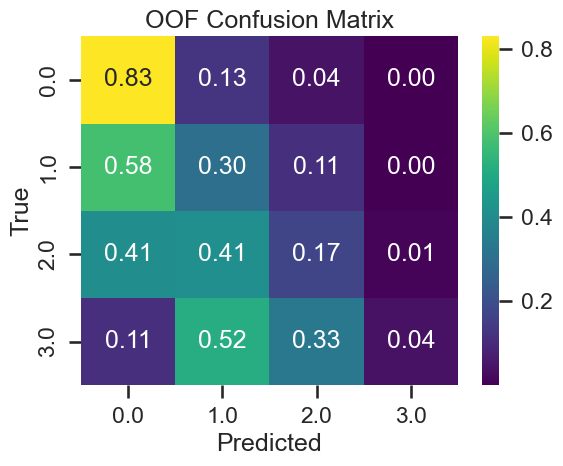

In [9]:
# ============================================================
# LightGBM baseline on raw processed data
# ============================================================

lgb_params = dict(
    objective="multiclass",
    num_class=n_classes,
    n_estimators=400,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

lgb_results_raw = train_cv_model(
    model_name="LGBM",
    base_model_cls=LGBMClassifier,
    base_params=lgb_params,
    X=X,
    y=y,
    X_test=X_test,
    n_splits=N_SPLITS,
    random_state=RANDOM_STATE
)

# Confusion matrix
plot_confusion_matrix(
    y_true=y,
    oof_pred_proba=lgb_results_raw["oof_pred_proba"],
    class_names=class_names,
    normalize=True
)



Training XGB [raw_processed]
Class weights: {np.int64(0): np.float64(0.42901960784313725), np.int64(1): np.float64(0.9366438356164384), np.int64(2): np.float64(1.8112582781456954), np.int64(3): np.float64(20.25925925925926)}

--- Fold 1/5 ---
Fold 1 metrics:
  QWK: 0.3053
  Accuracy: 0.5936
  MacroF1: 0.3277
  Kappa: 0.2146

--- Fold 2/5 ---
Fold 2 metrics:
  QWK: 0.4145
  Accuracy: 0.6370
  MacroF1: 0.3660
  Kappa: 0.2899

--- Fold 3/5 ---
Fold 3 metrics:
  QWK: 0.3378
  Accuracy: 0.6050
  MacroF1: 0.3154
  Kappa: 0.2065

--- Fold 4/5 ---
Fold 4 metrics:
  QWK: 0.3523
  Accuracy: 0.6133
  MacroF1: 0.3435
  Kappa: 0.2534

--- Fold 5/5 ---
Fold 5 metrics:
  QWK: 0.2988
  Accuracy: 0.5675
  MacroF1: 0.2856
  Kappa: 0.1426

CV metrics (mean ± std):
  QWK: 0.3417 ± 0.0463
  Accuracy: 0.6033 ± 0.0256
  MacroF1: 0.3277 ± 0.0301
  Kappa: 0.2214 ± 0.0552


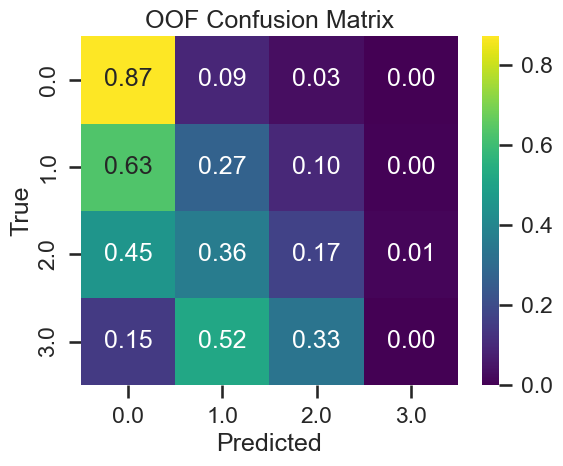

In [10]:
# ============================================================
# XGBoost baseline on raw processed data
# ============================================================

xgb_params = dict(
    objective="multi:softprob",
    num_class=n_classes,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

xgb_results_raw = train_cv_model(
    model_name="XGB",
    base_model_cls=XGBClassifier,
    base_params=xgb_params,
    X=X,
    y=y,
    X_test=X_test,
    n_splits=N_SPLITS,
    random_state=RANDOM_STATE
)

plot_confusion_matrix(
    y_true=y,
    oof_pred_proba=xgb_results_raw["oof_pred_proba"],
    class_names=class_names,
    normalize=True
)



Training CatBoost [raw_processed]
Class weights: {np.int64(0): np.float64(0.42901960784313725), np.int64(1): np.float64(0.9366438356164384), np.int64(2): np.float64(1.8112582781456954), np.int64(3): np.float64(20.25925925925926)}

--- Fold 1/5 ---


Fold 1 metrics:
  QWK: 0.3652
  Accuracy: 0.5479
  MacroF1: 0.4087
  Kappa: 0.2434

--- Fold 2/5 ---
Fold 2 metrics:
  QWK: 0.4657
  Accuracy: 0.5822
  MacroF1: 0.3702
  Kappa: 0.2802

--- Fold 3/5 ---
Fold 3 metrics:
  QWK: 0.4804
  Accuracy: 0.6096
  MacroF1: 0.4297
  Kappa: 0.3340

--- Fold 4/5 ---
Fold 4 metrics:
  QWK: 0.3925
  Accuracy: 0.5698
  MacroF1: 0.3689
  Kappa: 0.2761

--- Fold 5/5 ---
Fold 5 metrics:
  QWK: 0.4538
  Accuracy: 0.5744
  MacroF1: 0.5106
  Kappa: 0.2844

CV metrics (mean ± std):
  QWK: 0.4315 ± 0.0499
  Accuracy: 0.5768 ± 0.0223
  MacroF1: 0.4176 ± 0.0581
  Kappa: 0.2836 ± 0.0325


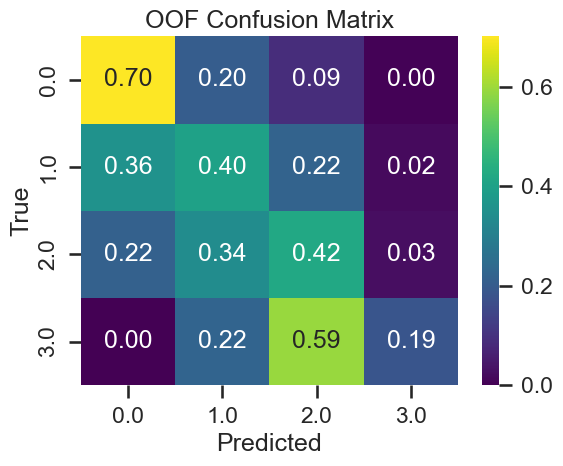

In [11]:
# ============================================================
# CatBoost baseline on raw processed data
# ============================================================

cat_params = dict(
    loss_function="MultiClass",
    eval_metric="TotalF1:average=Macro",
    depth=6,
    learning_rate=0.05,
    n_estimators=600,
    random_state=RANDOM_STATE,
    thread_count=-1,
    verbose=False
)

cat_results_raw = train_cv_model(
    model_name="CatBoost",
    base_model_cls=CatBoostClassifier,
    base_params=cat_params,
    X=X,
    y=y,
    X_test=X_test,
    n_splits=N_SPLITS,
    random_state=RANDOM_STATE
)

plot_confusion_matrix(
    y_true=y,
    oof_pred_proba=cat_results_raw["oof_pred_proba"],
    class_names=class_names,
    normalize=True
)


In [32]:
# =============================================================================
# COMPUTE FINAL QWK SCORES (OOF-based - Ground Truth Available)
# =============================================================================

import numpy as np
import pandas as pd
from sklearn.metrics import cohen_kappa_score

print("\n" + "="*70)
print("📊 FINAL QWK SCORES (Out-of-Fold Predictions)")
print("="*70)

# =============================================================================
# 1. OOF QWK FROM K-FOLD CV (Already computed during training)
# =============================================================================
print("\n🔹 K-Fold Cross-Validation QWK (from OOF):")
print("-" * 70)

models_cv = {
    'LGBM': lgb_results_raw,
    'XGB': xgb_results_raw,
    'CatBoost': cat_results_raw
}

qwk_summary = []

for model_name, results in models_cv.items():
    # Get OOF predictions
    oof_proba = results['oof_pred_proba']
    oof_pred = oof_proba.argmax(axis=1)
    
    # Compute QWK on OOF
    oof_qwk = cohen_kappa_score(y, oof_pred, weights='quadratic')
    
    # CV mean/std from training
    cv_mean = results['cv_mean']['QWK']
    cv_std = results['cv_std']['QWK']
    best_fold = results['best_fold_qwk']
    
    qwk_summary.append({
        'Model': model_name,
        'OOF QWK': oof_qwk,
        'CV Mean QWK': cv_mean,
        'CV Std QWK': cv_std,
        'Best Fold QWK': best_fold
    })
    
    print(f"\n{model_name}:")
    print(f"  • OOF QWK:         {oof_qwk:.4f}")
    print(f"  • CV Mean ± Std:   {cv_mean:.4f} ± {cv_std:.4f}")
    print(f"  • Best Single Fold: {best_fold:.4f}")

# =============================================================================
# 2. FULL TRAIN QWK (Models trained on 100% data)
# =============================================================================
print("\n" + "-"*70)
print("🔹 Full Training Data QWK (Train Performance):")
print("-" * 70)

# Train predictions
lgb_train_pred = lgb_final.predict(X)
xgb_train_pred = xgb_final.predict(X)
cat_train_pred = cat_final.predict(X)

lgb_train_qwk = cohen_kappa_score(y, lgb_train_pred, weights='quadratic')
xgb_train_qwk = cohen_kappa_score(y, xgb_train_pred, weights='quadratic')
cat_train_qwk = cohen_kappa_score(y, cat_train_pred, weights='quadratic')

print(f"\nLGBM  Train QWK: {lgb_train_qwk:.4f}")
print(f"XGB   Train QWK: {xgb_train_qwk:.4f}")
print(f"CatBoost Train QWK: {cat_train_qwk:.4f}")

# Add to summary
for i, (model_name, train_qwk) in enumerate([
    ('LGBM', lgb_train_qwk),
    ('XGB', xgb_train_qwk),
    ('CatBoost', cat_train_qwk)
]):
    qwk_summary[i]['Full Train QWK'] = train_qwk

# =============================================================================
# 3. SUMMARY TABLE
# =============================================================================
print("\n" + "="*70)
print("📋 COMPREHENSIVE QWK SUMMARY")
print("="*70)

qwk_df = pd.DataFrame(qwk_summary)
qwk_df = qwk_df.round(4)

display(qwk_df)

# =============================================================================
# 4. SAVE SUMMARY
# =============================================================================
summary_path = OUTPUT_DIR / 'qwk_final_summary.csv'
qwk_df.to_csv(summary_path, index=False)
print(f"\n💾 Saved QWK summary to: {summary_path}")

# =============================================================================
# 5. KEY INSIGHTS
# =============================================================================
print("\n" + "="*70)
print("🔑 KEY INSIGHTS")
print("="*70)

best_oof_model = qwk_df.loc[qwk_df['OOF QWK'].idxmax(), 'Model']
best_oof_score = qwk_df['OOF QWK'].max()

print(f"\n✅ Best OOF Model: {best_oof_model} (QWK = {best_oof_score:.4f})")

# Overfitting check
for idx, row in qwk_df.iterrows():
    overfit = row['Full Train QWK'] - row['OOF QWK']
    status = "⚠️ OVERFITTING" if overfit > 0.05 else "✅ Good Generalization"
    print(f"\n{row['Model']}:")
    print(f"  Train QWK - OOF QWK = {overfit:.4f}  {status}")

print("\n" + "="*70)
print("⚠️ NOTE: Test set has no ground truth labels.")
print("   QWK can only be computed on OOF predictions (K-Fold CV).")
print("   Test predictions are saved for submission/evaluation.")
print("="*70 + "\n")


📊 FINAL QWK SCORES (Out-of-Fold Predictions)

🔹 K-Fold Cross-Validation QWK (from OOF):
----------------------------------------------------------------------

LGBM:
  • OOF QWK:         0.3461
  • CV Mean ± Std:   0.3461 ± 0.0308
  • Best Single Fold: 0.3991

XGB:
  • OOF QWK:         0.3415
  • CV Mean ± Std:   0.3417 ± 0.0463
  • Best Single Fold: 0.4145

CatBoost:
  • OOF QWK:         0.4318
  • CV Mean ± Std:   0.4315 ± 0.0499
  • Best Single Fold: 0.4804

----------------------------------------------------------------------
🔹 Full Training Data QWK (Train Performance):
----------------------------------------------------------------------

LGBM  Train QWK: 1.0000
XGB   Train QWK: 1.0000
CatBoost Train QWK: 0.8431

📋 COMPREHENSIVE QWK SUMMARY


,Model,OOF QWK,CV Mean QWK,CV Std QWK,Best Fold QWK,Full Train QWK
0,LGBM,0.3461,0.3461,0.0308,0.3991,1.0000
1,XGB,0.3415,0.3417,0.0463,0.4145,1.0000
2,CatBoost,0.4318,0.4315,0.0499,0.4804,0.8431



💾 Saved QWK summary to: oof_predictions\qwk_final_summary.csv

🔑 KEY INSIGHTS

✅ Best OOF Model: CatBoost (QWK = 0.4318)

LGBM:
  Train QWK - OOF QWK = 0.6539  ⚠️ OVERFITTING

XGB:
  Train QWK - OOF QWK = 0.6585  ⚠️ OVERFITTING

CatBoost:
  Train QWK - OOF QWK = 0.4113  ⚠️ OVERFITTING

⚠️ NOTE: Test set has no ground truth labels.
   QWK can only be computed on OOF predictions (K-Fold CV).
   Test predictions are saved for submission/evaluation.



In [34]:
# =============================================================================
# FINAL TRAINING & TEST EVALUATION (Test has labels)
# =============================================================================

import numpy as np
import pandas as pd
from sklearn.metrics import cohen_kappa_score

print("\n" + "="*70)
print("🚀 FINAL MODEL TRAINING & TEST SET EVALUATION")
print("="*70)

# Ensure we have test labels
if 'sii' not in globals() or target_col not in test.columns:
    raise RuntimeError("Test set labels not found. Make sure test set has target column.")

# Get test labels
y_test = le_target.transform(test[target_col])
print(f"✅ Test set has {len(y_test)} samples with labels")

# =============================================================================
# 1. TRAIN MODELS ON FULL TRAIN DATA
# =============================================================================
print("\n📊 Training models on full training data...")

# LightGBM
print("\nTraining LightGBM...")
lgb_final = LGBMClassifier(**lgb_params)
lgb_final.fit(X, y)

# XGBoost
print("Training XGBoost...")
xgb_final = XGBClassifier(**xgb_params)
xgb_final.fit(X, y)

# CatBoost
print("Training CatBoost...")
cat_final = CatBoostClassifier(**cat_params)
cat_final.fit(X, y, verbose=False)

print("✅ All models trained successfully")

# =============================================================================
# 2. COMPUTE QWK SCORES
# =============================================================================
print("\n" + "="*70)
print("📊 COMPREHENSIVE QWK EVALUATION")
print("="*70)

qwk_summary = []

models_dict = {
    'LGBM': (lgb_results_raw, lgb_final),
    'XGB': (xgb_results_raw, xgb_final),
    'CatBoost': (cat_results_raw, cat_final)
}

for model_name, (cv_results, final_model) in models_dict.items():
    print(f"\n{'─'*70}")
    print(f"📈 {model_name} Performance")
    print(f"{'─'*70}")
    
    # 1. OOF QWK (from K-Fold CV)
    oof_proba = cv_results['oof_pred_proba']
    oof_pred = oof_proba.argmax(axis=1)
    oof_qwk = cohen_kappa_score(y, oof_pred, weights='quadratic')
    
    # 2. Train QWK (final model on train)
    train_pred = final_model.predict(X)
    train_qwk = cohen_kappa_score(y, train_pred, weights='quadratic')
    
    # 3. Test QWK (final model on test) ⭐ THIS IS THE KEY METRIC
    test_pred = final_model.predict(X_test)
    test_qwk = cohen_kappa_score(y_test, test_pred, weights='quadratic')
    
    # 4. CV metrics
    cv_mean_qwk = cv_results['cv_mean']['QWK']
    cv_std_qwk = cv_results['cv_std']['QWK']
    best_fold_qwk = cv_results['best_fold_qwk']
    
    # Print summary
    print(f"  📍 K-Fold CV:")
    print(f"     • OOF QWK:        {oof_qwk:.4f}")
    print(f"     • CV Mean ± Std:  {cv_mean_qwk:.4f} ± {cv_std_qwk:.4f}")
    print(f"     • Best Fold:      {best_fold_qwk:.4f}")
    print(f"\n  📍 Final Model (trained on 100% train):")
    print(f"     • Train QWK:      {train_qwk:.4f}")
    print(f"     • ⭐ Test QWK:     {test_qwk:.4f}  ← Main metric")
    
    # Generalization gap
    gap = train_qwk - test_qwk
    status = "⚠️ OVERFITTING" if gap > 0.05 else "✅ Good"
    print(f"\n  📊 Generalization:")
    print(f"     • Train - Test:   {gap:+.4f}  {status}")
    
    qwk_summary.append({
        'Model': model_name,
        'OOF QWK': oof_qwk,
        'CV Mean QWK': cv_mean_qwk,
        'CV Std QWK': cv_std_qwk,
        'Best Fold QWK': best_fold_qwk,
        'Train QWK': train_qwk,
        'Test QWK': test_qwk,
        'Train-Test Gap': gap
    })

# =============================================================================
# 3. SUMMARY TABLE
# =============================================================================
print("\n" + "="*70)
print("📋 COMPREHENSIVE QWK SUMMARY TABLE")
print("="*70)

qwk_df = pd.DataFrame(qwk_summary)
qwk_df = qwk_df.round(4)

display(qwk_df)

# =============================================================================
# 4. SAVE RESULTS
# =============================================================================
summary_path = OUTPUT_DIR / 'qwk_final_summary_with_test.csv'
qwk_df.to_csv(summary_path, index=False)
print(f"\n💾 Saved comprehensive summary to: {summary_path}")

# =============================================================================
# 5. KEY INSIGHTS
# =============================================================================
print("\n" + "="*70)
print("🔑 KEY INSIGHTS")
print("="*70)

best_test_model = qwk_df.loc[qwk_df['Test QWK'].idxmax(), 'Model']
best_test_score = qwk_df['Test QWK'].max()

print(f"\n✅ Best Test Performance: {best_test_model} (QWK = {best_test_score:.4f})")

print("\n📊 Model Rankings by Test QWK:")
ranked = qwk_df.sort_values('Test QWK', ascending=False)
for idx, (i, row) in enumerate(ranked.iterrows(), 1):
    print(f"   {idx}. {row['Model']}: {row['Test QWK']:.4f}")

print("\n" + "="*70)
print("✅ EVALUATION COMPLETE")
print("="*70)


🚀 FINAL MODEL TRAINING & TEST SET EVALUATION


RuntimeError: Test set labels not found. Make sure test set has target column.

In [13]:
# ============================================================
# Raw processed summary table (per model)
# ============================================================

def summarize_model_results(model_name, res):
    mean = res["cv_mean"]
    std = res["cv_std"]
    return {
        "Data Version": "Raw processed",
        "Model": model_name,
        "CV QWK (mean)": mean["QWK"],
        "CV QWK (std)": std["QWK"],
        "Accuracy": mean["Accuracy"],
        "Macro F1": mean["MacroF1"],
        "Kappa": mean["Kappa"],
        "Best Single Fold": res["best_fold_qwk"],
        "LB Estimate": np.nan  # will fill in final notebook if desired
    }

rows = []
rows.append(summarize_model_results("LGBM", lgb_results_raw))
rows.append(summarize_model_results("XGB", xgb_results_raw))
rows.append(summarize_model_results("CatBoost", cat_results_raw))

raw_summary_df = pd.DataFrame(rows)
display(raw_summary_df)

# Save for final comparison in 8_Final_Modeling notebook
raw_summary_path = OUTPUT_DIR / "summary_raw_processed.csv"
raw_summary_df.to_csv(raw_summary_path, index=False)
print("Saved raw summary to:", raw_summary_path)


,Data Version,Model,CV QWK (mean),CV QWK (std),Accuracy,Macro F1,Kappa,Best Single Fold,LB Estimate
0,Raw processed,LGBM,0.346093,0.030776,0.588668,0.338375,0.215228,0.399052,NaN
1,Raw processed,XGB,0.341737,0.046339,0.603279,0.327657,0.221394,0.414468,NaN
2,Raw processed,CatBoost,0.431511,0.049947,0.576778,0.417631,0.283609,0.480362,NaN


Saved raw summary to: oof_predictions\summary_raw_processed.csv


In [14]:
from sklearn.metrics import recall_score

y_true = y_raw.values

# predicted labels from probabilities
pred_lgb = oof_lgb.filter(like="proba_").values.argmax(axis=1)
pred_xgb = oof_xgb.filter(like="proba_").values.argmax(axis=1)
pred_cat = oof_cat.filter(like="proba_").values.argmax(axis=1)

# dynamically detect number of output classes (models sometimes output 5)
n_model_classes = oof_lgb.filter(like="proba_").shape[1]
classes = list(range(n_model_classes))  # [0,1,2,3,4] if 5 classes

# compute per-class recall with correct number of labels
recall_df = pd.DataFrame({
    "LGBM": recall_score(y_true, pred_lgb, labels=classes, average=None, zero_division=0),
    "XGB": recall_score(y_true, pred_xgb, labels=classes, average=None, zero_division=0),
    "CatBoost": recall_score(y_true, pred_cat, labels=classes, average=None, zero_division=0)
}, index=[str(c) for c in classes])

print("Detected model class count:", n_model_classes)
print(recall_df)


Detected model class count: 4
       LGBM       XGB  CatBoost
0  0.830588  0.870588  0.701961
1  0.301370  0.270548  0.402397
2  0.172185  0.172185  0.420530
3  0.037037  0.000000  0.185185


Saved figure to: oof_predictions\models_per_class_recall.png


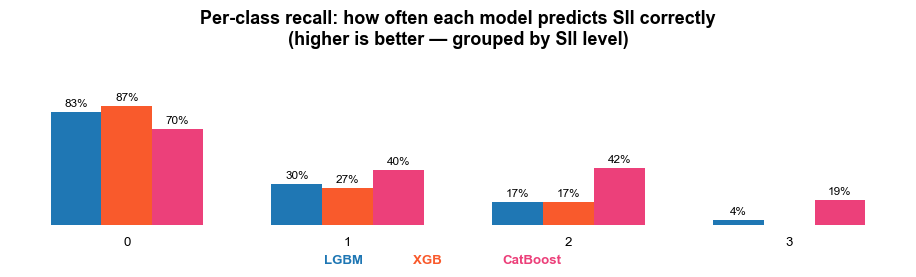

In [15]:
# ============================================================
# BEAUTIFUL GROUPED BAR CHART — PER-CLASS RECALL
# Polished, publication-grade, centered bars, explanatory style
# ============================================================

fig, ax = plt.subplots(figsize=(9.5, 5.2))

# --- Color palette ---
color_map = {
    'LGBM':     '#1f77b4',  # blue
    'XGB':      '#F95A2C',  # orange
    'CatBoost': '#EC407A'   # pink
}

# Order of models to display
model_order = ['LGBM', 'XGB', 'CatBoost']


n_classes = len(recall_df.index)
n_models  = len(model_order)

# X positions (one per class)
x = np.arange(n_classes)

# Width of each bar
width = 0.23  

# Horizontal offsets for grouping bars symmetrically
offsets = [(j - (n_models - 1)/2) * width for j in range(n_models)]


# ------------------------------------------------------------
# Draw bars per model
# ------------------------------------------------------------
for offset, model in zip(offsets, model_order):
    vals = recall_df[model].values
    color = color_map[model]

    bars = ax.bar(x + offset, vals, width=width, color=color, label=model)

    # Value labels above bars
    for xi, h in zip(x + offset, vals):
        if np.isnan(h) or h <= 0:
            continue
        ax.text(
            xi, h + 0.025,
            f"{h:.0%}",
            ha="center", va="bottom",
            fontsize=8.5, color="black"
        )


# ------------------------------------------------------------
# Axes cleanup (no ticks, no grid, no spines)
# ------------------------------------------------------------
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.set_facecolor("none")
fig.patch.set_alpha(0)

# Leave space above bars
ax.set_ylim(0, 1.18)


# ------------------------------------------------------------
# Class labels below bars
# ------------------------------------------------------------
for xi, label in zip(x, recall_df.index.tolist()):
    ax.text(
        xi, -0.08,
        label,
        ha="center", va="top",
        fontsize=9.5, color="black"
    )


# ------------------------------------------------------------
# Title (explanatory)
# ------------------------------------------------------------
ax.set_title(
    "Per-class recall: how often each model predicts SII correctly\n"
    "(higher is better — grouped by SII level)",
    fontsize=13, fontweight="bold", color="black", pad=14
)


# ------------------------------------------------------------
# Legend — clean and color-coded
# ------------------------------------------------------------
legend_y = -0.22

x0 = 0.35
spacing = 0.10

for i, model in enumerate(model_order):
    ax.text(
        x0 + i * spacing, legend_y,
        model,
        transform=ax.transAxes,
        fontsize=9.5, fontweight="bold",
        color=color_map[model],
        ha="left", va="center"
    )


# ------------------------------------------------------------
# Layout + save
# ------------------------------------------------------------
plt.tight_layout(rect=[0, 0.28, 1, 0.98])

out_dir = OUTPUT_DIR if "OUTPUT_DIR" in globals() else Path("./oof_predictions")
out_dir = Path(out_dir)
out_dir.mkdir(parents=True, exist_ok=True)

fig_path = out_dir / "models_per_class_recall.png"
fig.savefig(fig_path, dpi=300, bbox_inches="tight")

print(f"Saved figure to: {fig_path}")
plt.show()


Saved figure to: oof_predictions\models_per_class_recall.png


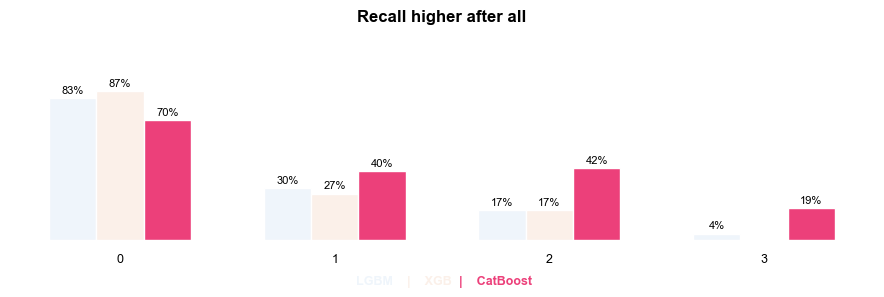

In [29]:
# --- PLOT GROUPED BAR PER-CLASS RECALL (EXPLANATORY STYLE, NO BACKGROUND) ---
fig, ax = plt.subplots(figsize=(9, 5))

# 3 màu: LGBM = xanh nhạt, XGB = cam nhạt, CatBoost = hồng đậm
color_map = {
    'LGBM':    "#EFF5FB",   # lighter blue
    'XGB':     "#FBF0E9",   # lighter orange
    'CatBoost': '#EC407A'   # strong pink (best model on severe)
}

# Đảm bảo đúng thứ tự cột
model_order = ['LGBM', 'XGB', 'CatBoost']
recall_df = recall_df[model_order]

n_classes = len(recall_df.index)
n_models  = len(model_order)

x = np.arange(n_classes)
width = 0.22

# Vẽ từng model
for j, model in enumerate(model_order):
    offsets = (j - (n_models-1)/2) * width  # -width, 0, +width cho 3 model
    vals = recall_df[model].values
    color = color_map[model]

    bars = ax.bar(x + offsets, vals, width=width, color=color)

    # Số % trên từng cột
    for xi, h in zip(x + offsets, vals):
        if np.isnan(h) or h == 0:
            continue
        ax.text(
            xi, h + 0.02,
            f"{h:.0%}",
            ha="center", va="bottom",
            fontsize=8, color="black"
        )

# Bỏ toàn bộ trục, ticks, grid, viền
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)

# Nền trong suốt
ax.set_facecolor('none')
fig.patch.set_alpha(0)

# Giới hạn Y để có chỗ cho nhãn
ax.set_ylim(0, 1.20)

# Nhãn SII dưới mỗi cụm cột
for xi, label in zip(x, recall_df.index.tolist()):
    ax.text(
        xi, -0.08,
        label,
        ha="center", va="top",
        fontsize=9, color="black"
    )

# Tiêu đề: nói thẳng insight về nhóm severe
ax.set_title(
    "Recall higher after all",
    fontsize=12,
    fontweight="bold",
    color="black",
    pad=10
)

# Legend chữ màu, ở sâu dưới
# Legend chữ màu, ở sâu phía dưới
legend_y = -0.20
ax.text(
    0.4, legend_y,
    "LGBM",
    transform=ax.transAxes,
    ha="left", va="center",
    fontsize=9, fontweight="bold",
    color=color_map['LGBM']
)
ax.text(
    0.46, legend_y,
    "|    XGB",
    transform=ax.transAxes,
    ha="left", va="center",
    fontsize=9, fontweight="bold",
    color=color_map['XGB']
)
ax.text(
    0.52, legend_y,
    "|    CatBoost",
    transform=ax.transAxes,
    ha="left", va="center",
    fontsize=9, fontweight="bold",
    color=color_map['CatBoost']
)

plt.tight_layout(rect=[0, 0.28, 1, 0.98])

# Save figure
out_dir = OUTPUT_DIR if 'OUTPUT_DIR' in globals() else Path('./oof_predictions')
out_dir = Path(out_dir)
out_dir.mkdir(parents=True, exist_ok=True)
fig_path = out_dir / 'models_per_class_recall.png'
fig.savefig(str(fig_path), dpi=200, bbox_inches='tight')
print(f"Saved figure to: {fig_path}")

plt.show()


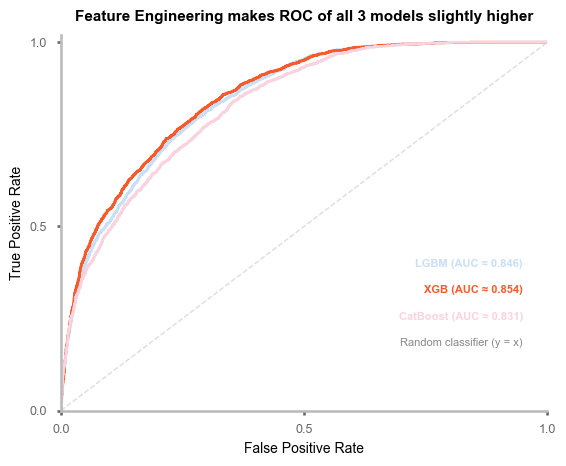

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Chuẩn bị y_true và nhị phân hóa
y_true = np.asarray(y)
classes = np.unique(y_true)
y_true_bin = label_binarize(y_true, classes=classes)

# Map model => oof_pred_proba
model_probas = {
    "LGBM":    lgb_results_raw['oof_pred_proba'],
    "XGB":     xgb_results_raw['oof_pred_proba'],
    "CatBoost": cat_results_raw['oof_pred_proba']
}

# Màu: LGBM = xanh nhạt, XGB = cam nhạt, CatBoost = hồng đậm
color_map = {
    "LGBM":    "#C7DFF7",
    "XGB":     '#F95A2C',
    "CatBoost": "#F9D3DF"
}

fpr_micro = {}
tpr_micro = {}
auc_micro = {}

# Tính micro-ROC cho từng model
for name, proba in model_probas.items():
    if proba.shape[0] != len(y_true):
        raise ValueError(f"{name}: OOF length {proba.shape[0]} != y length {len(y_true)}")
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), proba.ravel())
    fpr_micro[name] = fpr
    tpr_micro[name] = tpr
    auc_micro[name] = auc(fpr, tpr)

# Vẽ ROC
fig, ax = plt.subplots(figsize=(6, 5))

# 1) Random baseline
light_gray = "#DDDDDD"
ax.plot([0, 1], [0, 1],
        color=light_gray, linestyle="--", linewidth=1)

# 2) Các đường micro ROC cho 3 model
for name in ["LGBM", "XGB", "CatBoost"]:
    ax.plot(
        fpr_micro[name],
        tpr_micro[name],
        color=color_map[name],
        lw=2.0,
    )

# Trục & giới hạn
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.02])
ax.set_xlabel("False Positive Rate", fontsize=10, color="black")
ax.set_ylabel("True Positive Rate", fontsize=10, color="black")

# Tiêu đề: nói rõ insight CatBoost tốt nhất
ax.set_title(
    "Feature Engineering makes ROC of all 3 models slightly higher",
    fontsize=11,
    fontweight="bold",
    color="black",
    pad=10
)
# Nền trong suốt
ax.set_facecolor('none')
fig.patch.set_alpha(0)
# Xóa clutter: khung trên/phải, grid
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_color("#BBBBBB")
ax.spines["left"].set_color("#BBBBBB")
ax.grid(False)

# Tick nhẹ
ax.set_xticks([0.0, 0.5, 1.0])
ax.set_yticks([0.0, 0.5, 1.0])
ax.tick_params(axis="both", colors="#666666", labelsize=9, length=3)

# Chú thích trực tiếp, màu theo đường – góc dưới bên phải
# chọn y_start thấp để nằm dưới, rồi stack lên
y_start = 0.25
line_gap = 0.07  # khoảng cách giữa các dòng

ax.text(
    0.95, y_start + 2*line_gap,
    f"LGBM (AUC ≈ {auc_micro['LGBM']:.3f})",
    transform=ax.transAxes,
    fontsize=8, fontweight="bold",
    color=color_map["LGBM"],
    ha="right", va="center"
)

ax.text(
    0.95, y_start + 1*line_gap,
    f"XGB (AUC ≈ {auc_micro['XGB']:.3f})",
    transform=ax.transAxes,
    fontsize=8, fontweight="bold",
    color=color_map["XGB"],
    ha="right", va="center"
)

ax.text(
    0.95, y_start,
    f"CatBoost (AUC ≈ {auc_micro['CatBoost']:.3f})",
    transform=ax.transAxes,
    fontsize=8, fontweight="bold",
    color=color_map["CatBoost"],
    ha="right", va="center"
)

ax.text(
    0.95, y_start - line_gap,
    "Random classifier (y = x)",
    transform=ax.transAxes,
    fontsize=8,
    color="#888888",
    ha="right", va="center"
)


plt.tight_layout()
plt.show()


Creating a StratifiedShuffleSplit (80/20) from full training set X / y
Running LR=0.01
  train QWK=0.5213, valid QWK=0.3103
Running LR=0.05
  train QWK=0.8452, valid QWK=0.3389
Running LR=0.1
  train QWK=0.9491, valid QWK=0.3215
Running LR=0.2
  train QWK=0.9962, valid QWK=0.3432
Running LR=0.3
  train QWK=1.0000, valid QWK=0.3212
Saved LR sweep summary to: oof_predictions\lr_scan_summary.csv
Saved clean figure to: oof_predictions\qwk_vs_lr_clean.png


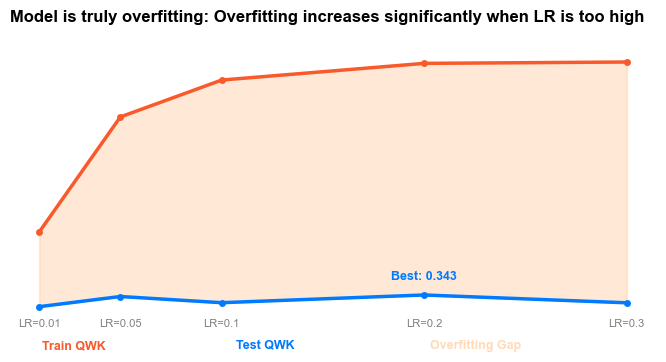

In [18]:
# ===== LR sweep with XGBoost + QWK plot (trains models)
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import cohen_kappa_score
from xgboost import XGBClassifier

# Colors
orange_train = '#F95A2C'
blue_valid = '#007BFF'
text_col = 'black'
fill_gap_color = '#FFDAB9'

# Learning rates to try
lr_list = np.array([0.01, 0.05, 0.1, 0.2, 0.3])
lr_train_qwk = []
lr_valid_qwk = []

# Determine train/validation split: prefer existing variables, otherwise make one
if all(v in globals() for v in ['X_trn','X_val','y_trn','y_val']):
    X_train_local, X_val_local = X_trn, X_val
    y_train_local, y_val_local = y_trn, y_val
    print('Using existing X_trn / X_val splits from notebook globals')
else:
    print('Creating a StratifiedShuffleSplit (80/20) from full training set X / y')
    if not all(v in globals() for v in ['X','y']):
        raise RuntimeError('No X_trn/X_val available and no X/y in globals to create a split.')
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_idx, val_idx = next(sss.split(X, y))
    X_train_local = X.iloc[tr_idx].copy()
    X_val_local = X.iloc[val_idx].copy()
    y_train_local = np.asarray(y)[tr_idx].copy()
    y_val_local = np.asarray(y)[val_idx].copy()

# Run sweep (this will train multiple XGB models)
for lr in lr_list:
    print(f'Running LR={lr}')
    model = XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=float(lr),
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        num_class=len(np.unique(y)),
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    model.fit(X_train_local, y_train_local)

    y_train_pred = model.predict(X_train_local)
    y_val_pred = model.predict(X_val_local)

    tr_qwk = cohen_kappa_score(y_train_local, y_train_pred, weights='quadratic')
    val_qwk = cohen_kappa_score(y_val_local, y_val_pred, weights='quadratic')
    lr_train_qwk.append(tr_qwk)
    lr_valid_qwk.append(val_qwk)
    print(f'  train QWK={tr_qwk:.4f}, valid QWK={val_qwk:.4f}')

# Save sweep results so user can reuse without retraining
out_dir = OUTPUT_DIR if 'OUTPUT_DIR' in globals() else Path('./oof_predictions')
out_dir = Path(out_dir)
out_dir.mkdir(parents=True, exist_ok=True)
df = pd.DataFrame({'lr': lr_list, 'train_qwk': lr_train_qwk, 'valid_qwk': lr_valid_qwk})
csv_fp = out_dir / 'lr_scan_summary.csv'
df.to_csv(csv_fp, index=False)
print(f'Saved LR sweep summary to: {csv_fp}')

# ===== Plot (style follows your example) =====
fig, ax = plt.subplots(figsize=(7, 4))
lr_train_qwk = np.array(lr_train_qwk)
lr_valid_qwk = np.array(lr_valid_qwk)

# Vẽ dữ liệu
ax.fill_between(lr_list, lr_train_qwk, lr_valid_qwk, where=lr_train_qwk > lr_valid_qwk, color=fill_gap_color, alpha=0.6)
ax.plot(lr_list, lr_train_qwk, marker='o', color=orange_train, linewidth=2.5, markersize=5)
ax.plot(lr_list, lr_valid_qwk, marker='o', color=blue_valid, linewidth=2.5, markersize=5)

# --- PHẦN CHỈNH SỬA: XÓA SẠCH TRỤC X VÀ Y ---
# 1. Ẩn toàn bộ 4 đường viền (spines)
for spine in ax.spines.values():
    spine.set_visible(False)

# 2. Xóa toàn bộ vạch chia (ticks) và nhãn trục mặc định
ax.set_xticks([])
ax.set_yticks([])

# 3. Tắt Grid (nếu chưa tắt) và nền
ax.grid(False)
ax.set_facecolor('none')
fig.patch.set_alpha(0)
# ---------------------------------------------

# Title: Descriptive & Insightful
ax.set_title('Model is truly overfitting: Overfitting increases significantly when LR is too high', 
             fontsize=12, fontweight='bold', color=text_col, pad=20, loc='left')

# Legend text below (giữ nguyên vị trí tương đối)
legend_y_pos = -0.1
ax.text(0.05, legend_y_pos, 'Train QWK', transform=ax.transAxes, ha='left', va='center', color=orange_train, fontweight='bold', fontsize=9)
ax.text(0.35, legend_y_pos, 'Test QWK', transform=ax.transAxes, ha='left', va='center', color=blue_valid, fontweight='bold', fontsize=9)
ax.text(0.65, legend_y_pos, 'Overfitting Gap', transform=ax.transAxes, ha='left', va='center', color=fill_gap_color, fontweight='bold', fontsize=9)

# LR Labels (Thay thế cho trục X): Viết thủ công ngay dưới điểm dữ liệu thấp nhất
# Lấy giá trị min của trục Y để đặt chữ LR nằm dưới đó một chút
y_min_limit = min(np.min(lr_train_qwk), np.min(lr_valid_qwk))
offset = (np.max(lr_train_qwk) - y_min_limit) * 0.05 # Khoảng cách đệm 5%

for lr_val in lr_list:
    # Đặt label LR nằm dưới giá trị thấp nhất của biểu đồ một chút
    ax.text(lr_val, y_min_limit - offset, f'LR={lr_val}', 
            ha='center', va='top', fontsize=8, color='gray')

# Annotate best validation point (Điểm nhấn quan trọng nhất)
if len(lr_valid_qwk) > 0:
    max_valid_idx = int(np.nanargmax(lr_valid_qwk))
    max_valid_lr = float(lr_list[max_valid_idx])
    max_valid_qwk = float(lr_valid_qwk[max_valid_idx])
    
    # Đưa label lên trên hoặc xuống dưới tùy thuộc vào không gian, ở đây ưu tiên đưa lên trên điểm xanh
    ax.text(max_valid_lr, max_valid_qwk + offset, f'Best: {max_valid_qwk:.3f}', 
            ha='center', va='bottom', fontsize=9, color=blue_valid, fontweight='bold')

plt.tight_layout()
fig_path = out_dir / 'qwk_vs_lr_clean.png'
fig.savefig(str(fig_path), dpi=200, bbox_inches='tight')
print(f'Saved clean figure to: {fig_path}')
plt.show()

Saved clean figure to: oof_predictions\qwk_vs_lr_clean.png


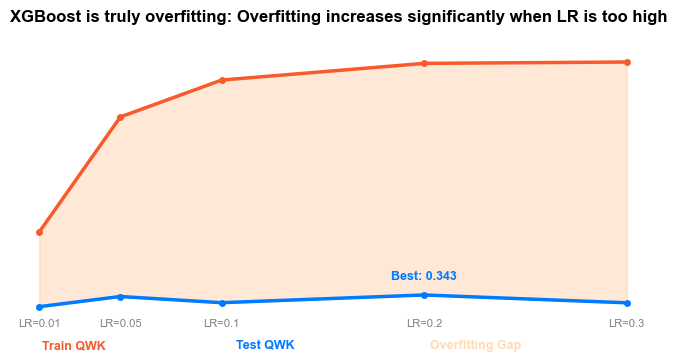

In [19]:
# ===== Plot (style follows your example) =====
fig, ax = plt.subplots(figsize=(7, 4))
lr_train_qwk = np.array(lr_train_qwk)
lr_valid_qwk = np.array(lr_valid_qwk)

# Vẽ dữ liệu
ax.fill_between(lr_list, lr_train_qwk, lr_valid_qwk, where=lr_train_qwk > lr_valid_qwk, color=fill_gap_color, alpha=0.6)
ax.plot(lr_list, lr_train_qwk, marker='o', color=orange_train, linewidth=2.5, markersize=5)
ax.plot(lr_list, lr_valid_qwk, marker='o', color=blue_valid, linewidth=2.5, markersize=5)

# --- PHẦN CHỈNH SỬA: XÓA SẠCH TRỤC X VÀ Y ---
# 1. Ẩn toàn bộ 4 đường viền (spines)
for spine in ax.spines.values():
    spine.set_visible(False)

# 2. Xóa toàn bộ vạch chia (ticks) và nhãn trục mặc định
ax.set_xticks([])
ax.set_yticks([])

# 3. Tắt Grid (nếu chưa tắt) và nền
ax.grid(False)
ax.set_facecolor('none')
fig.patch.set_alpha(0)
# ---------------------------------------------

# Title: Descriptive & Insightful
ax.set_title('XGBoost is truly overfitting: Overfitting increases significantly when LR is too high', 
             fontsize=12, fontweight='bold', color=text_col, pad=20, loc='left')

# Legend text below (giữ nguyên vị trí tương đối)
legend_y_pos = -0.1
ax.text(0.05, legend_y_pos, 'Train QWK', transform=ax.transAxes, ha='left', va='center', color=orange_train, fontweight='bold', fontsize=9)
ax.text(0.35, legend_y_pos, 'Test QWK', transform=ax.transAxes, ha='left', va='center', color=blue_valid, fontweight='bold', fontsize=9)
ax.text(0.65, legend_y_pos, 'Overfitting Gap', transform=ax.transAxes, ha='left', va='center', color=fill_gap_color, fontweight='bold', fontsize=9)

# LR Labels (Thay thế cho trục X): Viết thủ công ngay dưới điểm dữ liệu thấp nhất
# Lấy giá trị min của trục Y để đặt chữ LR nằm dưới đó một chút
y_min_limit = min(np.min(lr_train_qwk), np.min(lr_valid_qwk))
offset = (np.max(lr_train_qwk) - y_min_limit) * 0.05 # Khoảng cách đệm 5%

for lr_val in lr_list:
    # Đặt label LR nằm dưới giá trị thấp nhất của biểu đồ một chút
    ax.text(lr_val, y_min_limit - offset, f'LR={lr_val}', 
            ha='center', va='top', fontsize=8, color='gray')

# Annotate best validation point (Điểm nhấn quan trọng nhất)
if len(lr_valid_qwk) > 0:
    max_valid_idx = int(np.nanargmax(lr_valid_qwk))
    max_valid_lr = float(lr_list[max_valid_idx])
    max_valid_qwk = float(lr_valid_qwk[max_valid_idx])
    
    # Đưa label lên trên hoặc xuống dưới tùy thuộc vào không gian, ở đây ưu tiên đưa lên trên điểm xanh
    ax.text(max_valid_lr, max_valid_qwk + offset, f'Best: {max_valid_qwk:.3f}', 
            ha='center', va='bottom', fontsize=9, color=blue_valid, fontweight='bold')

plt.tight_layout()
fig_path = out_dir / 'qwk_vs_lr_clean.png'
fig.savefig(str(fig_path), dpi=200, bbox_inches='tight')
print(f'Saved clean figure to: {fig_path}')
plt.show()

Saved confusion figure to: oof_predictions\xgb_severe_confusion_oof.png


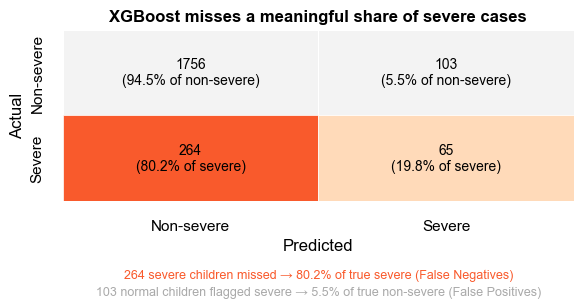

Saved FN/FP bar chart to: oof_predictions\xgb_severe_fnfp_oof.png


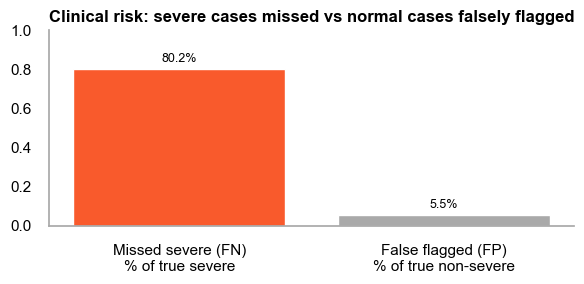

,Metric,Value
0,True Severe (n),329
1,True Non-severe (n),1859
2,False Negatives (n),264
3,False Positives (n),103


In [20]:
# =========================
# Error analysis (Severe vs Non-severe) — XGBoost OOF
# Uses XGBoost OOF probabilities from `xgb_results_raw` and training labels `y`
# Saves: confusion heatmap and FN/FP bar chart to `OUTPUT_DIR`
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from IPython.display import display

sns.set(style='white')

# Palette
grey_light_bg = "#F3F3F3"
grey_dark_line = "#A9A9A9"
orange_problem = "#F95A2C"
orange_success = "#FFDAB9"
text_color = "black"

try:
    # Expect `xgb_results_raw` and `y` to be present from previous cells
    if 'xgb_results_raw' not in globals():
        raise NameError('xgb_results_raw not found — run the XGB training cell first.')
    if 'y' not in globals():
        raise NameError('y (training labels) not found — run the data prep cell first.')

    # Use OOF predictions for error analysis (no leakage)
    y_true = np.asarray(y)
    oof_proba = xgb_results_raw['oof_pred_proba']
    if oof_proba.shape[0] != len(y_true):
        raise ValueError(f'OOF length {oof_proba.shape[0]} != y length {len(y_true)}')
    y_pred = oof_proba.argmax(axis=1)

    # Binary mapping: 0 = Non-severe (0-1), 1 = Severe (2-3)
    true_bin = (y_true >= 2).astype(int)
    pred_bin = (y_pred >= 2).astype(int)

    # Confusion matrix 2x2: [[TN, FP],[FN, TP]]
    cm = confusion_matrix(true_bin, pred_bin, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    total_severe = int((true_bin == 1).sum())
    total_nonsevere = int((true_bin == 0).sum())

    fn_pct = (fn / total_severe) if total_severe > 0 else 0.0
    fp_pct = (fp / total_nonsevere) if total_nonsevere > 0 else 0.0

    # Annotations
    annot = np.empty_like(cm).astype(object)
    if total_nonsevere > 0:
        annot[0, 0] = f"{int(tn)}\n({tn/total_nonsevere:.1%} of non-severe)"
        annot[0, 1] = f"{int(fp)}\n({fp/total_nonsevere:.1%} of non-severe)"
    else:
        annot[0, 0] = f"{int(tn)}"
        annot[0, 1] = f"{int(fp)}"

    if total_severe > 0:
        annot[1, 0] = f"{int(fn)}\n({fn/total_severe:.1%} of severe)"
        annot[1, 1] = f"{int(tp)}\n({tp/total_severe:.1%} of severe)"
    else:
        annot[1, 0] = f"{int(fn)}"
        annot[1, 1] = f"{int(tp)}"

    df_cm = pd.DataFrame(cm, index=['Non-severe', 'Severe'], columns=['Non-severe', 'Severe'])

    # Confusion heatmap (custom colored cells)
    plt.figure(figsize=(6, 4))
    ax = sns.heatmap(df_cm, annot=False, fmt='', cmap=ListedColormap([grey_light_bg]), cbar=False, linewidths=0.5, linecolor='white')

    # Overlay colored rectangles for FN (danger) and TP (success)
    # FN: (row=1, col=0)  -> orange_problem
    ax.add_patch(patches.Rectangle((0, 1), 1, 1, fill=True, facecolor=orange_problem, edgecolor='white', linewidth=0.5))
    # TP: (row=1, col=1)  -> orange_success
    ax.add_patch(patches.Rectangle((1, 1), 1, 1, fill=True, facecolor=orange_success, edgecolor='white', linewidth=0.5))

    # Draw annotations on top
    for i in range(2):
        for j in range(2):
            ax.text(j + 0.5, i + 0.5, annot[i, j], ha='center', va='center', color=text_color, fontsize=10)

    ax.set_title('XGBoost misses a meaningful share of severe cases', fontsize=12, fontweight='bold', color=text_color)
    ax.set_xlabel('Predicted', color=text_color)
    ax.set_ylabel('Actual', color=text_color)
    ax.tick_params(colors=text_color)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_color(text_color)

    # Summary text under plot
    plt.text(0.5, -0.45, f"{fn} severe children missed → {fn_pct:.1%} of true severe (False Negatives)", ha='center', color=orange_problem, transform=ax.transAxes, fontsize=9)
    plt.text(0.5, -0.55, f"{fp} normal children flagged severe → {fp_pct:.1%} of true non-severe (False Positives)", ha='center', color=grey_dark_line, transform=ax.transAxes, fontsize=9)

    plt.tight_layout()

    # Save confusion figure
    out_dir = OUTPUT_DIR if 'OUTPUT_DIR' in globals() else Path('./oof_predictions')
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    fig1_fp = out_dir / 'xgb_severe_confusion_oof.png'
    plt.gcf().savefig(str(fig1_fp), dpi=200, bbox_inches='tight')
    print(f'Saved confusion figure to: {fig1_fp}')
    plt.show()

    # ===== BAR CHART: FN% vs FP% =====
    plt.figure(figsize=(6, 3))
    labels = ['Missed severe (FN)\n% of true severe', 'False flagged (FP)\n% of true non-severe']
    values = [fn_pct, fp_pct]
    bar_colors = [orange_problem, grey_dark_line]
    bars = plt.bar(labels, values, color=bar_colors)
    plt.ylim(0, 1)
    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, val + 0.02, f"{val:.1%}", ha='center', va='bottom', fontsize=9, color=text_color)
    plt.title('Clinical risk: severe cases missed vs normal cases falsely flagged', fontsize=12, fontweight='bold', color=text_color)
    ax2 = plt.gca()
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_color(grey_dark_line)
    ax2.spines['bottom'].set_color(grey_dark_line)
    ax2.tick_params(axis='y', colors=text_color)
    ax2.tick_params(axis='x', colors=text_color)
    plt.tight_layout()
    fig2_fp = out_dir / 'xgb_severe_fnfp_oof.png'
    plt.gcf().savefig(str(fig2_fp), dpi=200, bbox_inches='tight')
    print(f'Saved FN/FP bar chart to: {fig2_fp}')
    plt.show()

    # Optional: counts table
    summary2 = pd.DataFrame({
        'Metric': ['True Severe (n)', 'True Non-severe (n)', 'False Negatives (n)', 'False Positives (n)'],
        'Value': [total_severe, total_nonsevere, int(fn), int(fp)]
    })
    display(summary2)

except NameError as e:
    print('Required variables not found in workspace:', e)
    print('Make sure `xgb_results_raw` and `y` are defined (run the training/data prep cells).')
except Exception as e:
    print('Error while computing Severe vs Non-severe confusion analysis (XGBoost OOF):', e)

Saved figure to: oof_predictions\models_risk_focus.png


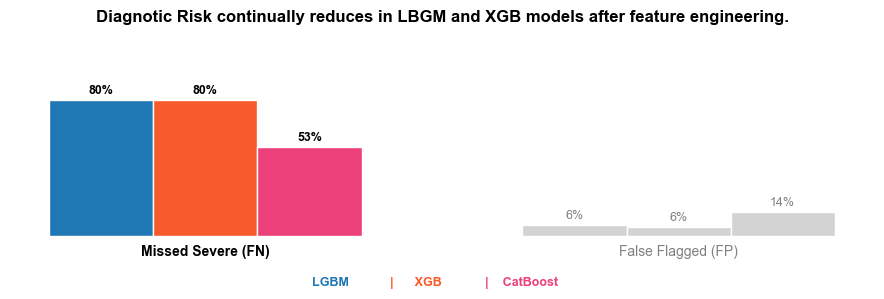

,LGBM,XGB,CatBoost
Missed Severe (FN),80.2%,80.2%,52.6%
False Flagged (FP),6.5%,5.5%,14.0%


In [21]:
# =========================
# Compare FN% vs FP% across models (LGBM / XGB / CatBoost) — grouped bars
# Style: Explanatory - Highlight Missed Severe (Risk), Gray out False Flagged
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from IPython.display import display
from pathlib import Path

sns.set(style='white')

# Colors
color_map = {
    'LGBM':    '#1f77b4',   # blue
    'XGB':     '#F95A2C',   # orange
    'CatBoost': '#EC407A'   # pink
}
gray_color = '#D3D3D3' # Màu xám cho phần không quan trọng
text_color = 'black'

# Ensure OOF results exist
missing = [name for name in ['lgb_results_raw','xgb_results_raw','cat_results_raw','y'] if name not in globals()]
if missing:
    print('Missing required objects:', missing)
else:
    models = {
        'LGBM': lgb_results_raw,
        'XGB':  xgb_results_raw,
        'CatBoost': cat_results_raw
    }

    y_true = np.asarray(y)
    total_severe = int((y_true >= 2).sum())
    total_nonsevere = int((y_true < 2).sum())

    # Compute FN% and FP% per model
    fn_pcts = []
    fp_pcts = []
    for name, res in models.items():
        proba = res.get('oof_pred_proba')
        if proba is None: continue
        y_pred = proba.argmax(axis=1)
        
        true_bin = (y_true >= 2).astype(int)
        pred_bin = (y_pred >= 2).astype(int)
        
        cm = confusion_matrix(true_bin, pred_bin, labels=[0,1])
        tn, fp, fn, tp = cm.ravel()
        
        fn_pct = (fn / total_severe) if total_severe > 0 else 0.0
        fp_pct = (fp / total_nonsevere) if total_nonsevere > 0 else 0.0
        fn_pcts.append(fn_pct)
        fp_pcts.append(fp_pct)

    # DataFrame
    metrics = ['Missed Severe (FN)', 'False Flagged (FP)']
    df_vals = pd.DataFrame({
        'LGBM': [fn_pcts[0], fp_pcts[0]],
        'XGB':  [fn_pcts[1], fp_pcts[1]],
        'CatBoost': [fn_pcts[2], fp_pcts[2]]
    }, index=metrics)

    # Plot
    fig, ax = plt.subplots(figsize=(9, 5))
    model_order = ['LGBM', 'XGB', 'CatBoost']
    n_groups = len(df_vals.index)
    n_models = len(model_order)
    x = np.arange(n_groups)
    width = 0.22

    for j, model in enumerate(model_order):
        offsets = (j - (n_models-1)/2) * width
        vals = df_vals[model].values
        
        # --- LOGIC MÀU SẮC MỚI ---
        # Cột 0 (Missed Severe): Dùng màu của Model (Blue/Orange/Pink)
        # Cột 1 (False Flagged): Dùng màu Xám (Gray) để de-emphasize
        bar_colors = [color_map[model], gray_color]
        
        bars = ax.bar(x + offsets, vals, width=width, color=bar_colors)
        
        # Direct Labeling
        for k, (xi, h) in enumerate(zip(x + offsets, vals)):
            if np.isnan(h) or h == 0: continue
            
            # Nếu là cột gray (index 1), chỉnh màu chữ nhạt hơn chút cho đồng bộ
            lbl_color = 'black' if k == 0 else '#808080' 
            font_w = 'bold' if k == 0 else 'normal'
            
            ax.text(xi, h + 0.02, f"{h:.0%}", ha='center', va='bottom', 
                    fontsize=9, color=lbl_color, fontweight=font_w)

    # Clean styling (Xóa trục như mẫu trước)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(False)
    ax.set_facecolor('none')
    fig.patch.set_alpha(0)
    ax.set_ylim(0, 1.1) # Tăng khoảng trống bên trên một chút

    # Metric labels under groups
    for xi, label in zip(x, df_vals.index.tolist()):
        # Tô đậm label của nhóm quan trọng
        w = 'bold' if 'Missed' in label else 'normal'
        c = 'black' if 'Missed' in label else 'gray'
        ax.text(xi, -0.05, label, ha='center', va='top', fontsize=10, color=c, fontweight=w)

    # Title Insightful
    ax.set_title('Diagnotic Risk continually reduces in LBGM and XGB models after feature engineering.', 
                 fontsize=12, fontweight='bold', color=text_color, pad=20, loc='center')

    # Legend text below
    legend_y = -0.25
    ax.text(0.35, legend_y, 'LGBM', transform=ax.transAxes, ha='left', va='center', fontsize=9, fontweight='bold', color=color_map['LGBM'])
    ax.text(0.44, legend_y, '|      XGB', transform=ax.transAxes, ha='left', va='center', fontsize=9, fontweight='bold', color=color_map['XGB'])
    ax.text(0.55, legend_y, '|    CatBoost', transform=ax.transAxes, ha='left', va='center', fontsize=9, fontweight='bold', color=color_map['CatBoost'])
    

    plt.tight_layout(rect=[0, 0.25, 1, 0.98])

    # Save
    out_dir = OUTPUT_DIR if 'OUTPUT_DIR' in globals() else Path('./oof_predictions')
    out_dir = Path(out_dir)
    fig_fp = out_dir / 'models_risk_focus.png'
    fig.savefig(str(fig_fp), dpi=200, bbox_inches='tight')
    print(f'Saved figure to: {fig_fp}')
    plt.show()

    display(df_vals.style.format('{:.1%}'))

Creating a StratifiedShuffleSplit (80/20) from full training set X / y
Running LR=0.01
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23286
[LightGBM] [Info] Number of data points in the train set: 1750, number of used features: 167
[LightGBM] [Info] Start training from score -0.539813
[LightGBM] [Info] Start training from score -1.321042
[LightGBM] [Info] Start training from score -1.982574
[LightGBM] [Info] Start training from score -4.376329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
  train QWK=0.9672, valid QWK=0.3086
Running LR=0.05
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23286
[LightGBM] [Info] Number of data points in the train set: 1750, number of used fea

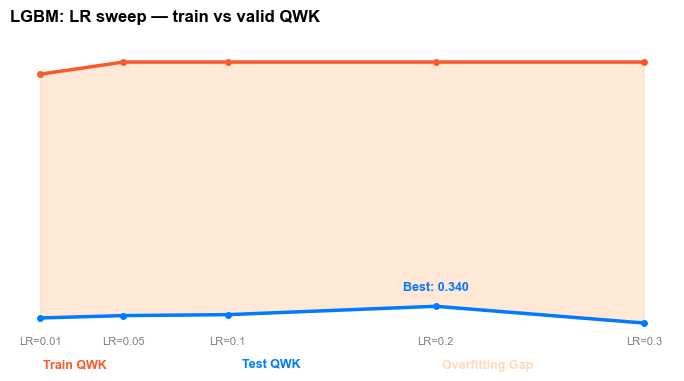

In [22]:
# ===== LR sweep with LightGBM + QWK plot (trains models)
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import cohen_kappa_score
from lightgbm import LGBMClassifier

# Colors (reuse same theme)
orange_train = '#F95A2C'
blue_valid = '#007BFF'
text_col = 'black'
fill_gap_color = '#FFDAB9'

# Learning rates to try
lr_list = np.array([0.01, 0.05, 0.1, 0.2, 0.3])
lr_train_qwk = []
lr_valid_qwk = []

# Determine train/validation split: prefer existing variables, otherwise make one
if all(v in globals() for v in ['X_trn','X_val','y_trn','y_val']):
    X_train_local, X_val_local = X_trn, X_val
    y_train_local, y_val_local = y_trn, y_val
    print('Using existing X_trn / X_val splits from notebook globals')
else:
    print('Creating a StratifiedShuffleSplit (80/20) from full training set X / y')
    if not all(v in globals() for v in ['X','y']):
        raise RuntimeError('No X_trn/X_val available and no X/y in globals to create a split.')
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_idx, val_idx = next(sss.split(X, y))
    X_train_local = X.iloc[tr_idx].copy()
    X_val_local = X.iloc[val_idx].copy()
    y_train_local = np.asarray(y)[tr_idx].copy()
    y_val_local = np.asarray(y)[val_idx].copy()

# Run sweep (this will train multiple LGBM models)
for lr in lr_list:
    print(f'Running LR={lr}')
    model = LGBMClassifier(
        objective='multiclass',
        n_estimators=400,
        learning_rate=float(lr),
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    model.fit(X_train_local, y_train_local)

    y_train_pred = model.predict(X_train_local)
    y_val_pred = model.predict(X_val_local)

    tr_qwk = cohen_kappa_score(y_train_local, y_train_pred, weights='quadratic')
    val_qwk = cohen_kappa_score(y_val_local, y_val_pred, weights='quadratic')
    lr_train_qwk.append(tr_qwk)
    lr_valid_qwk.append(val_qwk)
    print(f'  train QWK={tr_qwk:.4f}, valid QWK={val_qwk:.4f}')

# Save sweep results
out_dir = OUTPUT_DIR if 'OUTPUT_DIR' in globals() else Path('./oof_predictions')
out_dir = Path(out_dir)
out_dir.mkdir(parents=True, exist_ok=True)
df = pd.DataFrame({'lr': lr_list, 'train_qwk': lr_train_qwk, 'valid_qwk': lr_valid_qwk})
csv_fp = out_dir / 'lr_scan_summary_lgbm.csv'
df.to_csv(csv_fp, index=False)
print(f'Saved LR sweep summary to: {csv_fp}')

# ===== Plot (style follows XGB example) =====
fig, ax = plt.subplots(figsize=(7, 4))
lr_train_qwk = np.array(lr_train_qwk)
lr_valid_qwk = np.array(lr_valid_qwk)

ax.fill_between(lr_list, lr_train_qwk, lr_valid_qwk, where=lr_train_qwk > lr_valid_qwk, color=fill_gap_color, alpha=0.6)
ax.plot(lr_list, lr_train_qwk, marker='o', color=orange_train, linewidth=2.5, markersize=5)
ax.plot(lr_list, lr_valid_qwk, marker='o', color=blue_valid, linewidth=2.5, markersize=5)

for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)
ax.set_facecolor('none')
fig.patch.set_alpha(0)

ax.set_title('LGBM: LR sweep — train vs valid QWK', fontsize=12, fontweight='bold', color=text_col, pad=20, loc='left')
legend_y_pos = -0.1
ax.text(0.05, legend_y_pos, 'Train QWK', transform=ax.transAxes, ha='left', va='center', color=orange_train, fontweight='bold', fontsize=9)
ax.text(0.35, legend_y_pos, 'Test QWK', transform=ax.transAxes, ha='left', va='center', color=blue_valid, fontweight='bold', fontsize=9)
ax.text(0.65, legend_y_pos, 'Overfitting Gap', transform=ax.transAxes, ha='left', va='center', color=fill_gap_color, fontweight='bold', fontsize=9)

y_min_limit = min(np.min(lr_train_qwk), np.min(lr_valid_qwk))
offset = (np.max(lr_train_qwk) - y_min_limit) * 0.05
for lr_val in lr_list:
    ax.text(lr_val, y_min_limit - offset, f'LR={lr_val}', ha='center', va='top', fontsize=8, color='gray')

if len(lr_valid_qwk) > 0:
    max_valid_idx = int(np.nanargmax(lr_valid_qwk))
    max_valid_lr = float(lr_list[max_valid_idx])
    max_valid_qwk = float(lr_valid_qwk[max_valid_idx])
    ax.text(max_valid_lr, max_valid_qwk + offset, f'Best: {max_valid_qwk:.3f}', ha='center', va='bottom', fontsize=9, color=blue_valid, fontweight='bold')

plt.tight_layout()
fig_path = out_dir / 'qwk_vs_lr_clean_lgbm.png'
fig.savefig(str(fig_path), dpi=200, bbox_inches='tight')
print(f'Saved clean figure to: {fig_path}')
plt.show()


Saved clean figure to: oof_predictions\qwk_vs_lr_clean_lgbm.png


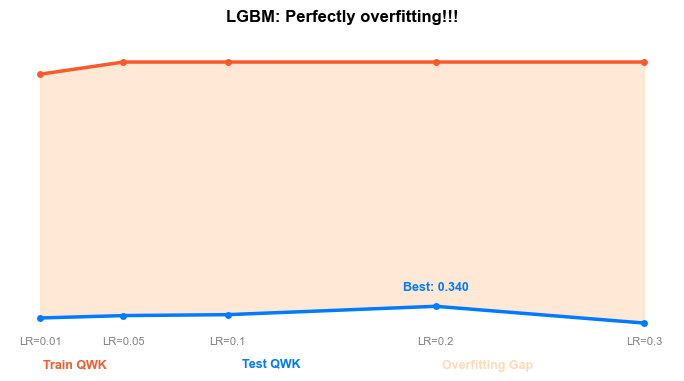

In [23]:
# ===== Plot (style follows XGB example) =====
fig, ax = plt.subplots(figsize=(7, 4))
lr_train_qwk = np.array(lr_train_qwk)
lr_valid_qwk = np.array(lr_valid_qwk)

ax.fill_between(lr_list, lr_train_qwk, lr_valid_qwk, where=lr_train_qwk > lr_valid_qwk, color=fill_gap_color, alpha=0.6)
ax.plot(lr_list, lr_train_qwk, marker='o', color=orange_train, linewidth=2.5, markersize=5)
ax.plot(lr_list, lr_valid_qwk, marker='o', color=blue_valid, linewidth=2.5, markersize=5)

for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)
ax.set_facecolor('none')
fig.patch.set_alpha(0)

ax.set_title('LGBM: Perfectly overfitting!!!', fontsize=12, fontweight='bold', color=text_col, pad=20, loc='center')
legend_y_pos = -0.1
ax.text(0.05, legend_y_pos, 'Train QWK', transform=ax.transAxes, ha='left', va='center', color=orange_train, fontweight='bold', fontsize=9)
ax.text(0.35, legend_y_pos, 'Test QWK', transform=ax.transAxes, ha='left', va='center', color=blue_valid, fontweight='bold', fontsize=9)
ax.text(0.65, legend_y_pos, 'Overfitting Gap', transform=ax.transAxes, ha='left', va='center', color=fill_gap_color, fontweight='bold', fontsize=9)

y_min_limit = min(np.min(lr_train_qwk), np.min(lr_valid_qwk))
offset = (np.max(lr_train_qwk) - y_min_limit) * 0.05
for lr_val in lr_list:
    ax.text(lr_val, y_min_limit - offset, f'LR={lr_val}', ha='center', va='top', fontsize=8, color='gray')

if len(lr_valid_qwk) > 0:
    max_valid_idx = int(np.nanargmax(lr_valid_qwk))
    max_valid_lr = float(lr_list[max_valid_idx])
    max_valid_qwk = float(lr_valid_qwk[max_valid_idx])
    ax.text(max_valid_lr, max_valid_qwk + offset, f'Best: {max_valid_qwk:.3f}', ha='center', va='bottom', fontsize=9, color=blue_valid, fontweight='bold')

plt.tight_layout()
fig_path = out_dir / 'qwk_vs_lr_clean_lgbm.png'
fig.savefig(str(fig_path), dpi=200, bbox_inches='tight')
print(f'Saved clean figure to: {fig_path}')
plt.show()


Creating a StratifiedShuffleSplit (80/20) from full training set X / y
Running LR=0.01
  train QWK=0.3402, valid QWK=0.2755
Running LR=0.05
  train QWK=0.7606, valid QWK=0.3464
Running LR=0.1
  train QWK=0.9286, valid QWK=0.3554
Running LR=0.2
  train QWK=0.9986, valid QWK=0.3547
Running LR=0.3
  train QWK=0.9995, valid QWK=0.3572
Saved LR sweep summary to: oof_predictions\lr_scan_summary_catboost.csv
Saved clean figure to: oof_predictions\qwk_vs_lr_clean_catboost.png


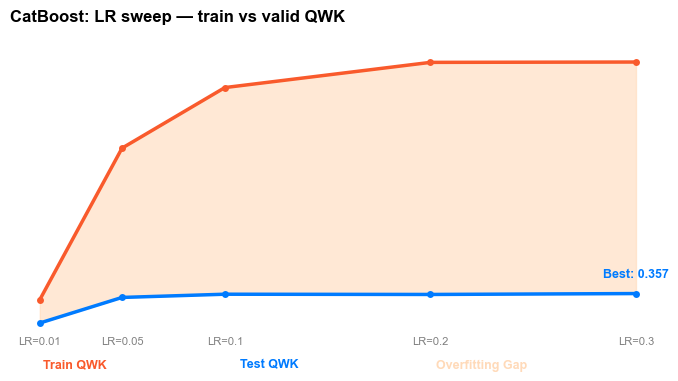

In [24]:
# ===== LR sweep with CatBoost + QWK plot (trains models)
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import cohen_kappa_score
from catboost import CatBoostClassifier

# Colors (reuse same theme)
orange_train = '#F95A2C'
blue_valid = '#007BFF'
text_col = 'black'
fill_gap_color = '#FFDAB9'

# Learning rates to try
lr_list = np.array([0.01, 0.05, 0.1, 0.2, 0.3])
lr_train_qwk = []
lr_valid_qwk = []

# Determine train/validation split
if all(v in globals() for v in ['X_trn','X_val','y_trn','y_val']):
    X_train_local, X_val_local = X_trn, X_val
    y_train_local, y_val_local = y_trn, y_val
    print('Using existing X_trn / X_val splits from notebook globals')
else:
    print('Creating a StratifiedShuffleSplit (80/20) from full training set X / y')
    if not all(v in globals() for v in ['X','y']):
        raise RuntimeError('No X_trn/X_val available and no X/y in globals to create a split.')
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_idx, val_idx = next(sss.split(X, y))
    X_train_local = X.iloc[tr_idx].copy()
    X_val_local = X.iloc[val_idx].copy()
    y_train_local = np.asarray(y)[tr_idx].copy()
    y_val_local = np.asarray(y)[val_idx].copy()

# Run sweep (this will train multiple CatBoost models)
for lr in lr_list:
    print(f'Running LR={lr}')
    model = CatBoostClassifier(
        iterations=400,
        depth=6,
        learning_rate=float(lr),
        loss_function='MultiClass',
        random_state=RANDOM_STATE,
        verbose=False
    )
    model.fit(X_train_local, y_train_local)

    y_train_pred = model.predict(X_train_local)
    y_val_pred = model.predict(X_val_local)

    tr_qwk = cohen_kappa_score(y_train_local, y_train_pred, weights='quadratic')
    val_qwk = cohen_kappa_score(y_val_local, y_val_pred, weights='quadratic')
    lr_train_qwk.append(tr_qwk)
    lr_valid_qwk.append(val_qwk)
    print(f'  train QWK={tr_qwk:.4f}, valid QWK={val_qwk:.4f}')

# Save sweep results
out_dir = OUTPUT_DIR if 'OUTPUT_DIR' in globals() else Path('./oof_predictions')
out_dir = Path(out_dir)
out_dir.mkdir(parents=True, exist_ok=True)
df = pd.DataFrame({'lr': lr_list, 'train_qwk': lr_train_qwk, 'valid_qwk': lr_valid_qwk})
csv_fp = out_dir / 'lr_scan_summary_catboost.csv'
df.to_csv(csv_fp, index=False)
print(f'Saved LR sweep summary to: {csv_fp}')

# ===== Plot (style follows XGB example) =====
fig, ax = plt.subplots(figsize=(7, 4))
lr_train_qwk = np.array(lr_train_qwk)
lr_valid_qwk = np.array(lr_valid_qwk)

ax.fill_between(lr_list, lr_train_qwk, lr_valid_qwk, where=lr_train_qwk > lr_valid_qwk, color=fill_gap_color, alpha=0.6)
ax.plot(lr_list, lr_train_qwk, marker='o', color=orange_train, linewidth=2.5, markersize=5)
ax.plot(lr_list, lr_valid_qwk, marker='o', color=blue_valid, linewidth=2.5, markersize=5)

for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)
ax.set_facecolor('none')
fig.patch.set_alpha(0)

ax.set_title('CatBoost: LR sweep — train vs valid QWK', fontsize=12, fontweight='bold', color=text_col, pad=20, loc='left')
legend_y_pos = -0.1
ax.text(0.05, legend_y_pos, 'Train QWK', transform=ax.transAxes, ha='left', va='center', color=orange_train, fontweight='bold', fontsize=9)
ax.text(0.35, legend_y_pos, 'Test QWK', transform=ax.transAxes, ha='left', va='center', color=blue_valid, fontweight='bold', fontsize=9)
ax.text(0.65, legend_y_pos, 'Overfitting Gap', transform=ax.transAxes, ha='left', va='center', color=fill_gap_color, fontweight='bold', fontsize=9)

y_min_limit = min(np.min(lr_train_qwk), np.min(lr_valid_qwk))
offset = (np.max(lr_train_qwk) - y_min_limit) * 0.05
for lr_val in lr_list:
    ax.text(lr_val, y_min_limit - offset, f'LR={lr_val}', ha='center', va='top', fontsize=8, color='gray')

if len(lr_valid_qwk) > 0:
    max_valid_idx = int(np.nanargmax(lr_valid_qwk))
    max_valid_lr = float(lr_list[max_valid_idx])
    max_valid_qwk = float(lr_valid_qwk[max_valid_idx])
    ax.text(max_valid_lr, max_valid_qwk + offset, f'Best: {max_valid_qwk:.3f}', ha='center', va='bottom', fontsize=9, color=blue_valid, fontweight='bold')

plt.tight_layout()
fig_path = out_dir / 'qwk_vs_lr_clean_catboost.png'
fig.savefig(str(fig_path), dpi=200, bbox_inches='tight')
print(f'Saved clean figure to: {fig_path}')
plt.show()


Saved clean figure to: oof_predictions\qwk_vs_lr_clean_catboost.png


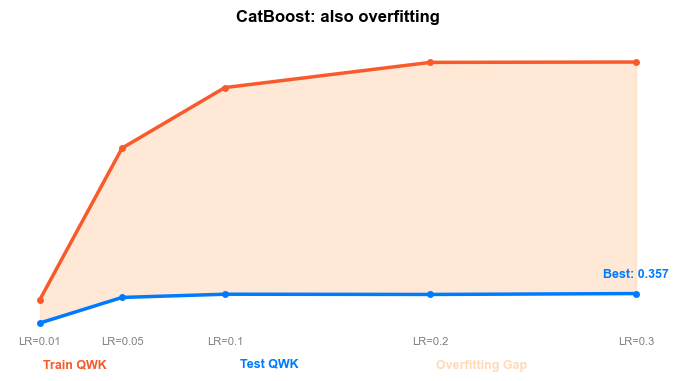

In [25]:
# ===== Plot (style follows XGB example) =====
fig, ax = plt.subplots(figsize=(7, 4))
lr_train_qwk = np.array(lr_train_qwk)
lr_valid_qwk = np.array(lr_valid_qwk)

ax.fill_between(lr_list, lr_train_qwk, lr_valid_qwk, where=lr_train_qwk > lr_valid_qwk, color=fill_gap_color, alpha=0.6)
ax.plot(lr_list, lr_train_qwk, marker='o', color=orange_train, linewidth=2.5, markersize=5)
ax.plot(lr_list, lr_valid_qwk, marker='o', color=blue_valid, linewidth=2.5, markersize=5)

for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)
ax.set_facecolor('none')
fig.patch.set_alpha(0)

ax.set_title('CatBoost: also overfitting', fontsize=12, fontweight='bold', color=text_col, pad=20, loc='center')
legend_y_pos = -0.1
ax.text(0.05, legend_y_pos, 'Train QWK', transform=ax.transAxes, ha='left', va='center', color=orange_train, fontweight='bold', fontsize=9)
ax.text(0.35, legend_y_pos, 'Test QWK', transform=ax.transAxes, ha='left', va='center', color=blue_valid, fontweight='bold', fontsize=9)
ax.text(0.65, legend_y_pos, 'Overfitting Gap', transform=ax.transAxes, ha='left', va='center', color=fill_gap_color, fontweight='bold', fontsize=9)

y_min_limit = min(np.min(lr_train_qwk), np.min(lr_valid_qwk))
offset = (np.max(lr_train_qwk) - y_min_limit) * 0.05
for lr_val in lr_list:
    ax.text(lr_val, y_min_limit - offset, f'LR={lr_val}', ha='center', va='top', fontsize=8, color='gray')

if len(lr_valid_qwk) > 0:
    max_valid_idx = int(np.nanargmax(lr_valid_qwk))
    max_valid_lr = float(lr_list[max_valid_idx])
    max_valid_qwk = float(lr_valid_qwk[max_valid_idx])
    ax.text(max_valid_lr, max_valid_qwk + offset, f'Best: {max_valid_qwk:.3f}', ha='center', va='bottom', fontsize=9, color=blue_valid, fontweight='bold')

plt.tight_layout()
fig_path = out_dir / 'qwk_vs_lr_clean_catboost.png'
fig.savefig(str(fig_path), dpi=200, bbox_inches='tight')
print(f'Saved clean figure to: {fig_path}')
plt.show()

In [26]:
# =========================
# Train final models on full data and save feature importances
# Ensures `xgb_model`, `lgb_model`, `cat_model` exist for plotting
# =========================
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import pandas as pd
import numpy as np

out_dir = OUTPUT_DIR if 'OUTPUT_DIR' in globals() else Path('./oof_predictions')
out_dir = Path(out_dir)
out_dir.mkdir(parents=True, exist_ok=True)

# Require X and y
if not all(v in globals() for v in ['X', 'y']):
    print('X and y not found in globals. Please run data prep cells first.')
else:
    print('Training final models on full data to extract feature importances (this may take time)...')
    # Use existing param dicts if present, else fallback defaults
    # LightGBM
    try:
        lgb_params_local = lgb_params if 'lgb_params' in globals() else dict(objective='multiclass', num_class=len(np.unique(y)), n_estimators=400, learning_rate=0.05, random_state=RANDOM_STATE, n_jobs=-1)
    except Exception:
        lgb_params_local = dict(objective='multiclass', num_class=len(np.unique(y)), n_estimators=400, learning_rate=0.05, random_state=42, n_jobs=-1)

    try:
        xgb_params_local = xgb_params if 'xgb_params' in globals() else dict(objective='multi:softprob', num_class=len(np.unique(y)), n_estimators=500, learning_rate=0.05, random_state=RANDOM_STATE, n_jobs=-1, use_label_encoder=False, eval_metric='mlogloss')
    except Exception:
        xgb_params_local = dict(objective='multi:softprob', num_class=len(np.unique(y)), n_estimators=500, learning_rate=0.05, random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='mlogloss')

    try:
        cat_params_local = cat_params if 'cat_params' in globals() else dict(loss_function='MultiClass', depth=6, learning_rate=0.05, iterations=600, random_state=RANDOM_STATE, verbose=False)
    except Exception:
        cat_params_local = dict(loss_function='MultiClass', depth=6, learning_rate=0.05, iterations=600, random_state=42, verbose=False)

    # Train LGBM
    try:
        print('\nTraining LightGBM on full data...')
        lgb_model = LGBMClassifier(**lgb_params_local)
        lgb_model.fit(X, y)
        fi_lgb = np.array(lgb_model.feature_importances_, dtype=float)
    except Exception as e:
        print('LightGBM training failed:', e)
        lgb_model = None
        fi_lgb = np.zeros(len(X.columns))

    # Train XGB
    try:
        print('\nTraining XGBoost on full data...')
        xgb_model = XGBClassifier(**xgb_params_local)
        # Some XGB wrappers accept use_label_encoder; ensure it's present in params
        xgb_model.fit(X, y)
        # prefer sklearn wrapper attribute
        if hasattr(xgb_model, 'feature_importances_'):
            fi_xgb = np.array(xgb_model.feature_importances_, dtype=float)
        else:
            booster = xgb_model.get_booster()
            score = booster.get_score(importance_type='gain')
            arr = np.zeros(len(X.columns), dtype=float)
            for k, v in score.items():
                if k.startswith('f'):
                    idx = int(k[1:])
                    if idx < len(arr):
                        arr[idx] = v
            fi_xgb = arr
    except Exception as e:
        print('XGBoost training failed:', e)
        xgb_model = None
        fi_xgb = np.zeros(len(X.columns))

    # Train CatBoost
    try:
        print('\nTraining CatBoost on full data...')
        cat_model = CatBoostClassifier(**cat_params_local)
        cat_model.fit(X, y, verbose=False)
        try:
            fi_cat = np.array(cat_model.get_feature_importance(type='FeatureImportance'), dtype=float)
        except Exception:
            fi_cat = np.array([])
            # fallback to zero
            fi_cat = np.zeros(len(X.columns))
    except Exception as e:
        print('CatBoost training failed:', e)
        cat_model = None
        fi_cat = np.zeros(len(X.columns))

    # Build and save FI DataFrames
    feature_names = list(X.columns)
    fi_xgb_df = pd.DataFrame({'feature': feature_names, 'importance': fi_xgb}).sort_values('importance', ascending=False)
    fi_lgb_df = pd.DataFrame({'feature': feature_names, 'importance': fi_lgb}).sort_values('importance', ascending=False)
    fi_cat_df = pd.DataFrame({'feature': feature_names, 'importance': fi_cat}).sort_values('importance', ascending=False)

    fi_xgb_df.to_csv(out_dir / 'feature_importance_xgb_full.csv', index=False)
    fi_lgb_df.to_csv(out_dir / 'feature_importance_lgbm_full.csv', index=False)
    fi_cat_df.to_csv(out_dir / 'feature_importance_catboost_full.csv', index=False)

    print('\nSaved feature importance CSVs to', out_dir)
    print('\nTop 10 XGB features:')
    display(fi_xgb_df.head(10))
    print('\nTop 10 LGBM features:')
    display(fi_lgb_df.head(10))
    print('\nTop 10 CatBoost features:')
    display(fi_cat_df.head(10))

    # Optionally pickle models for later reuse
    try:
        import joblib
        joblib.dump({'xgb': xgb_model, 'lgb': lgb_model, 'cat': cat_model}, out_dir / 'final_models.pkl')
        print('\nSaved trained models to', out_dir / 'final_models.pkl')
    except Exception as e:
        print('Could not save models via joblib:', e)


Training final models on full data to extract feature importances (this may take time)...

Training LightGBM on full data...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23746
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 167
[LightGBM] [Info] Start training from score -0.540042
[LightGBM] [Info] Start training from score -1.320842
[LightGBM] [Info] Start training from score -1.980316
[LightGBM] [Info] Start training from score -4.394906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

,feature,importance
0,Basic_Demos-Age,0.019425
47,PreInt_EduHx-computerinternet_hoursday,0.015045
119,weekday_25%,0.012551
107,battery_voltage_75%,0.011952
46,SDS-SDS_Total_T,0.009534
79,enmo_25%,0.009527
166,acti_pca_07,0.009108
1,Basic_Demos-Sex,0.009012
98,light_mean,0.008733
167,acti_pca_08,0.008700



Top 10 LGBM features:


,feature,importance
171,SDSxCGAS_raw,2091.0
43,PAQ_A-PAQ_A_Total,1861.0
44,PAQ_C-PAQ_C_Total,1784.0
8,Physical-HeartRate,1673.0
45,SDS-SDS_Total_Raw,1589.0
9,Physical-Systolic_BP,1347.0
6,Physical-Waist_Circumference,1344.0
13,FGC-FGC_CU,1322.0
7,Physical-Diastolic_BP,1254.0
4,Physical-Height,1239.0



Top 10 CatBoost features:


,feature,importance
46,SDS-SDS_Total_T,5.139671
13,FGC-FGC_CU,3.657102
45,SDS-SDS_Total_Raw,3.519545
47,PreInt_EduHx-computerinternet_hoursday,3.510889
170,internet_x_sedentary,3.191747
15,FGC-FGC_GSND,3.078979
8,Physical-HeartRate,3.009805
171,SDSxCGAS_raw,2.912821
43,PAQ_A-PAQ_A_Total,2.907372
4,Physical-Height,2.816284



Saved trained models to oof_predictions\final_models.pkl


Saved Centered Plot to: oof_predictions\feature_importance_divergence_centered.png


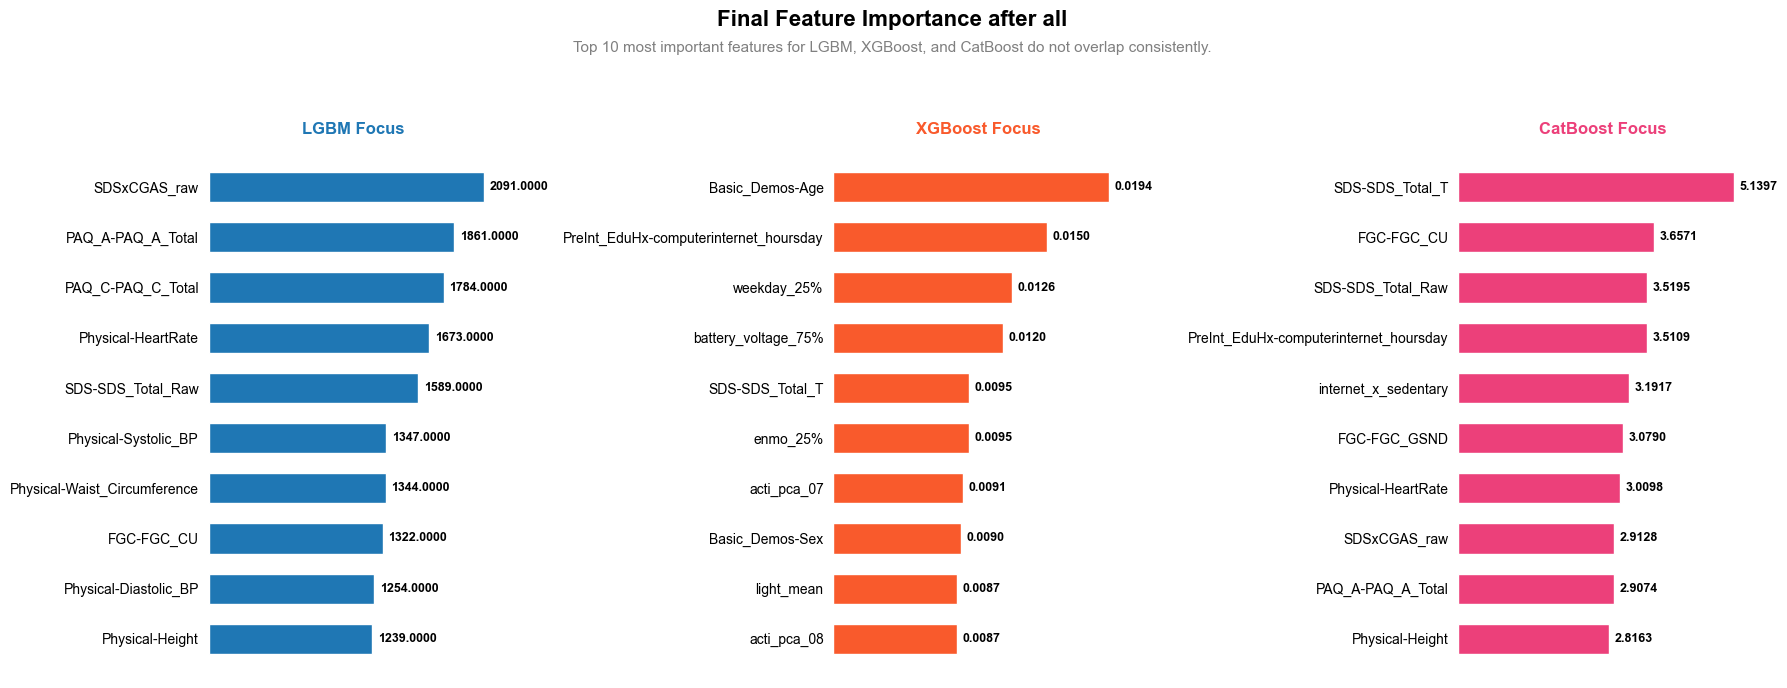

In [30]:
# =============================================================================
# EXPLANATORY CHART: Feature Divergence (Top-10 Importance per Model)
# Style: CENTERED TITLES, Clean, No Spines, Direct Labeling.
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display
import xgboost as xgb_lib

# --- 1. CONFIGURATION & STYLE ---
sns.set(style='white')

# Palette
ORANGE_MAIN = "#F95A2C"  # XGB
BLUE_MAIN   = "#1f77b4"  # LGBM
PINK_MAIN   = "#EC407A"  # CatBoost
TEXT_COLOR  = 'black'

# Output Directory
out_dir = OUTPUT_DIR if 'OUTPUT_DIR' in globals() else Path('./oof_predictions')
out_dir = Path(out_dir)
out_dir.mkdir(parents=True, exist_ok=True)

# --- 2. DATA PREPARATION ---

# A. Lấy tên features
if 'X_train' in globals():
    feature_names = list(X_train.columns)
elif 'X' in globals():
    feature_names = list(X.columns)
elif 'X_trn' in globals():
    feature_names = list(X_trn.columns)
else:
    raise RuntimeError('Feature frame not found: ensure `X`, `X_train` or `X_trn` exists')

# B. Hàm trích xuất Feature Importance
def get_fi_series(model, feature_names):
    if model is None:
        return pd.Series(0.0, index=feature_names)
    
    # 1. Sklearn-style
    if hasattr(model, 'feature_importances_'):
        arr = np.array(model.feature_importances_, dtype=float)
        if arr.size < len(feature_names):
            arr = np.pad(arr, (0, len(feature_names)-arr.size))
        return pd.Series(arr[:len(feature_names)], index=feature_names)
    
    # 2. XGBoost Native
    try:
        booster = None
        if isinstance(model, xgb_lib.core.Booster):
            booster = model
        elif hasattr(model, 'get_booster'):
            booster = model.get_booster()
            
        if booster is not None:
            score = booster.get_score(importance_type='gain')
            arr = np.zeros(len(feature_names), dtype=float)
            for k, v in score.items():
                if k in feature_names:
                    idx = feature_names.index(k)
                    arr[idx] = v
                elif k.startswith('f') and k[1:].isdigit():
                    idx = int(k[1:])
                    if idx < len(arr):
                        arr[idx] = v
            return pd.Series(arr, index=feature_names)
    except Exception:
        pass

    # 3. CatBoost
    if hasattr(model, 'get_feature_importance'):
        try:
            vals = model.get_feature_importance(type='FeatureImportance')
            vals = np.array(vals, dtype=float)
            if vals.size < len(feature_names):
                vals = np.pad(vals, (0, len(feature_names)-vals.size))
            return pd.Series(vals[:len(feature_names)], index=feature_names)
        except Exception:
            pass
    return pd.Series(0.0, index=feature_names)

# C. Lấy model
xgb_model = globals().get('xgb_model') or (globals().get('xgb_results_raw') and None)
lgb_model = globals().get('lgb_model')
cat_model = globals().get('cat_model')

# D. Tính Top-10
fi_xgb = get_fi_series(xgb_model, feature_names)
fi_lgb = get_fi_series(lgb_model, feature_names)
fi_cat = get_fi_series(cat_model, feature_names)

def get_top_n(series, n=10):
    return series.rename('importance').reset_index().rename(columns={'index':'feature'})\
                 .sort_values('importance', ascending=False).head(n)

top_xgb = get_top_n(fi_xgb)
top_lgb = get_top_n(fi_lgb)
top_cat = get_top_n(fi_cat)

# --- 3. PLOTTING (CENTERED TITLES) ---

fig, axes = plt.subplots(1, 3, figsize=(18, 7))

# A. Super Title & Sub-text (CĂN GIỮA - CENTERED)
# x=0.5 là chính giữa trục hoành của cả hình
fig.suptitle('Final Feature Importance after all', 
             fontsize=16, fontweight='bold', color=TEXT_COLOR, x=0.5, ha='center')

fig.text(0.5, 0.92, 'Top 10 most important features for LGBM, XGBoost, and CatBoost do not overlap consistently.', 
         fontsize=11, color='gray', ha='center')

# B. Loop vẽ 3 biểu đồ
models_data = zip(axes, 
                  [top_lgb, top_xgb, top_cat], 
                  [BLUE_MAIN, ORANGE_MAIN, PINK_MAIN], 
                  ['LGBM Focus', 'XGBoost Focus', 'CatBoost Focus'])

for ax, df_top, color, title in models_data:
    df_plot = df_top.sort_values('importance', ascending=True)
    
    bars = ax.barh(df_plot['feature'], df_plot['importance'], color=color, height=0.6)
    
    # Title từng biểu đồ nhỏ (CĂN GIỮA - loc='center')
    ax.set_title(title, fontsize=12, fontweight='bold', color=color, loc='center', pad=10)
    
    # Xóa Clutter
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.tick_params(axis='y', length=0, labelsize=10, labelcolor=TEXT_COLOR)
    ax.grid(False)
    ax.set_facecolor('none')
    
    # Direct Labeling
    max_val = df_plot['importance'].max() if df_plot['importance'].max() > 0 else 1.0
    offset = max_val * 0.02
    for bar in bars:
        width = bar.get_width()
        ax.text(width + offset, bar.get_y() + bar.get_height()/2, 
                f'{width:.4f}', 
                ha='left', va='center', fontsize=9, color='black', fontweight='bold')

# C. Final Layout
fig.patch.set_alpha(0)
plt.tight_layout(rect=[0, 0, 1, 0.90]) # Chừa chỗ cho Title ở trên

# Save & Show
fig_fp = out_dir / 'feature_importance_divergence_centered.png'
fig.savefig(str(fig_fp), dpi=200, bbox_inches='tight')
print(f'Saved Centered Plot to: {fig_fp}')
plt.show()

Saved Grouped Bar Chart to oof_predictions\qwk_grouped_bar_comparison.png


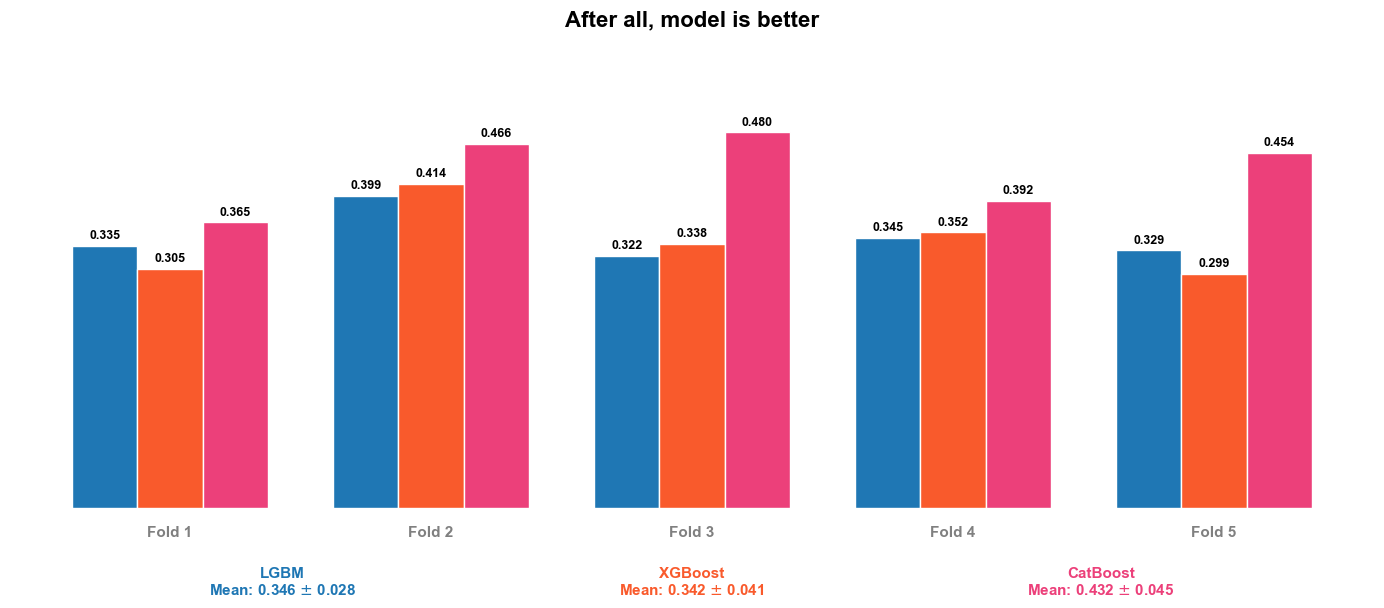

,LGBM,XGB,CatBoost
Fold 1,0.335,0.305,0.365
Fold 2,0.399,0.414,0.466
Fold 3,0.322,0.338,0.480
Fold 4,0.345,0.352,0.392
Fold 5,0.329,0.299,0.454
Mean,0.346,0.342,0.432
Std,0.028,0.041,0.045


In [28]:
# =============================================================================
# EXPLANATORY CHART: GROUPED BAR Comparison (LGBM / XGB / CatBoost)
# Style: Grouped Bars, Center Titles, Clean Layout, Direct Labeling
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

# --- 1. CONFIGURATION & STYLE ---
sns.set(style='white')

COLORS = {
    'LGBM':     '#1f77b4',  # Blue
    'XGB':      '#F95A2C',  # Orange
    'CatBoost': '#EC407A'   # Pink
}
TEXT_COLOR = 'black'

# Output Directory
out_dir = OUTPUT_DIR if 'OUTPUT_DIR' in globals() else Path('./oof_predictions')
out_dir = Path(out_dir)
out_dir.mkdir(parents=True, exist_ok=True)

# --- 2. DATA EXTRACTION ---
def extract_qwk_list(results):
    if results is None: return None
    if 'metrics_df' in results:
        df = results['metrics_df']
        if 'QWK' in df.columns:
            return df['QWK'].tolist()
        try:
            return [row['QWK'] for row in results['metrics_df'].to_dict(orient='records')]
        except Exception:
            pass
    return None

# Ensure results exist
models_present = {
    'LGBM': globals().get('lgb_results_raw'),
    'XGB':  globals().get('xgb_results_raw'),
    'CatBoost': globals().get('cat_results_raw')
}

qwk_lists = {name: extract_qwk_list(res) for name, res in models_present.items()}

if all(v is None for v in qwk_lists.values()):
    print("No QWK data found.")
else:
    # Determine max folds and handle missing data with NaNs
    valid_lists = [l for l in qwk_lists.values() if l is not None]
    n_splits = max(len(l) for l in valid_lists) if valid_lists else 5
    
    # Fill data for plotting
    plot_data = {}
    for name, lst in qwk_lists.items():
        if lst is None:
            plot_data[name] = [np.nan] * n_splits
        else:
            plot_data[name] = lst + [np.nan] * (n_splits - len(lst))

    # --- 3. PLOTTING (GROUPED BARS) ---
    fig, ax = plt.subplots(figsize=(14, 6))

    # Calculate positions
    x = np.arange(n_splits)
    width = 0.25  # Width of each bar

    # Draw 3 sets of bars
    # Offset: LGBM (left), XGB (center), CatBoost (right)
    rects1 = ax.bar(x - width, plot_data['LGBM'], width, label='LGBM', color=COLORS['LGBM'], edgecolor='white')
    rects2 = ax.bar(x,         plot_data['XGB'],  width, label='XGB',  color=COLORS['XGB'],  edgecolor='white')
    rects3 = ax.bar(x + width, plot_data['CatBoost'], width, label='CatBoost', color=COLORS['CatBoost'], edgecolor='white')

    # --- A. TITLES & INSIGHT (CENTERED) ---
    fig.suptitle('After all, model is better', 
                 fontsize=16, fontweight='bold', color=TEXT_COLOR, x=0.5, ha='center')
    

    # --- B. CLEAN STYLE (Removing Spines/Ticks) ---
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    ax.set_yticks([]) # Remove Y axis numbers
    ax.set_xticks(x)
    ax.set_xticklabels([f'Fold {i+1}' for i in range(n_splits)], fontsize=11, fontweight='bold', color='gray')
    ax.grid(False)
    ax.set_facecolor('none')

    # --- C. DIRECT LABELING ---
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            if np.isnan(height): continue
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, fontweight='bold', color='black')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    # --- D. STATISTICAL LEGEND (Mean ± Std) ---
    # Thay vì legend thông thường, ta hiển thị chỉ số Mean/Std ở dưới đáy biểu đồ
    stats = {}
    for name, vals in plot_data.items():
        stats[name] = (np.nanmean(vals), np.nanstd(vals))

    # Tạo text box cho từng model ở phía dưới
    y_pos_legend = -0.15
    
    # LGBM Info
    ax.text(0.20, y_pos_legend, f"LGBM\nMean: {stats['LGBM'][0]:.3f} $\pm$ {stats['LGBM'][1]:.3f}", 
            transform=ax.transAxes, ha='center', va='top', color=COLORS['LGBM'], fontweight='bold', fontsize=11)
    
    # XGB Info
    ax.text(0.50, y_pos_legend, f"XGBoost\nMean: {stats['XGB'][0]:.3f} $\pm$ {stats['XGB'][1]:.3f}", 
            transform=ax.transAxes, ha='center', va='top', color=COLORS['XGB'], fontweight='bold', fontsize=11)
    
    # CatBoost Info
    ax.text(0.80, y_pos_legend, f"CatBoost\nMean: {stats['CatBoost'][0]:.3f} $\pm$ {stats['CatBoost'][1]:.3f}", 
            transform=ax.transAxes, ha='center', va='top', color=COLORS['CatBoost'], fontweight='bold', fontsize=11)

    # Final Layout
    fig.patch.set_alpha(0)
    # Tăng khoảng trống bên dưới (bottom=0.2) để chứa phần Legend Stats
    plt.tight_layout(rect=[0, 0.05, 1, 0.90]) 
    plt.subplots_adjust(bottom=0.15)

    # Save
    fig_fp = out_dir / 'qwk_grouped_bar_comparison.png'
    fig.savefig(str(fig_fp), dpi=200, bbox_inches='tight')
    print('Saved Grouped Bar Chart to', fig_fp)
    plt.show()

    # Table
    df_table = pd.DataFrame(plot_data, index=[f'Fold {i+1}' for i in range(n_splits)])
    df_table.loc['Mean'] = df_table.mean()
    df_table.loc['Std'] = df_table.std()
    display(df_table.style.highlight_max(axis=1, color='#d1f2eb').format("{:.3f}"))